In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 67.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import numpy as np
from transformers import AutoTokenizer, AutoModel, AdamW, AutoConfig, get_linear_schedule_with_warmup
from transformers.modeling_outputs import TokenClassifierOutput
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch import nn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
import time, datetime
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Skripsi/Data/data_sentimen.csv')
df

,Unnamed: 0,id,date,tweet,sentimen
0,1,1.575992e+18,2022-09-30,@damprad komunis mengakibatkan kelaparan\nkapi...,1
1,13,1.575884e+18,2022-09-30,"@FOOD_FESS Betul, aku baru sadar kalo gula bik...",0
2,16,1.575878e+18,2022-09-30,Diabetes dan Obesitas Mengintai: Lindungi Masy...,1
3,27,1.575838e+18,2022-09-30,@ohmybeautybank Bagian leher tuh katanya menan...,1
4,37,1.575800e+18,2022-09-30,@caratstalk Kalo horangdan bisa lah agak gede ...,2
...,...,...,...,...,...
9995,21175,1.239579e+18,2020-03-16,"@sekarawe Ironis ya terkadang, ada aja guru sd...",1
9996,21207,1.239531e+18,2020-03-16,@shitlicious Dan toilet duduk juga seharusnya ...,1
9997,21227,1.239509e+18,2020-03-16,Overweight menuju obesitas\nYok diet yok,0
9998,21245,1.239486e+18,2020-03-16,Sinyal internet tolong jangan ikut-ikutan jaga...,2


In [ ]:
df['sentimen'].describe()

count    10000.000000
mean         0.910900
std          0.885347
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: sentimen, dtype: float64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


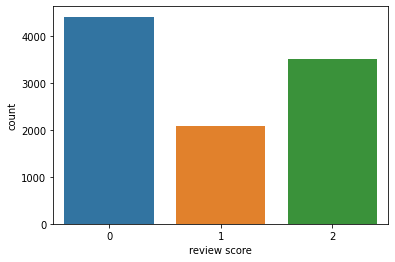

In [ ]:
sns.countplot(df.sentimen)
plt.xlabel('review score');

In [ ]:
character = ['.',',',';',':','-,','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# hapus karakter yang berulang
def repeatcharClean(text): 
  for i in range(len(character)):
    charac_long = 10
    while charac_long > 2:
      char = character[i]*charac_long 
      text = text.replace(char,character[i])
      charac_long -= 1
  return text

def cleaning_text(text):
  text = text.lower() #case folding
  #Url
  text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", text)
  text = re.sub(r"@[^\s]+[\s]?", ' ', text) #username
  text = re.sub(r'#(\S+)', r'\1', text) #hastag
  text = re.sub(r'[^\w\s]', ' ', text) #tandabaca
  text = re.sub('[^a-zA-Z,.?!]+',' ',text) #angka dan simbol
  text = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", ' ', text) #emoticon
  text = re.sub(':[A-Za-z_-]+:', ' ', text) # delete emoji
  text = repeatcharClean(text) #delete repeat alphabet
  text = re.sub('[ ]+',' ',text) #enter to spasi
  text = re.sub('  +', ' ', text) # Remove extra spaces
  return text

In [ ]:
tweets = df['tweet'].values
sentimen = df['sentimen'].values

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

In [ ]:
input_ids = []
for text in tweets:
  text = cleaning_text(text)
  encoding = tokenizer.encode(str(text), add_special_tokens = True, return_attention_mask=True, padding='max_length', truncation=True, max_length=78)
  input_ids.append(encoding)

In [ ]:
print("Max sentence length: ", max([len(sen) for sen in input_ids]))

Max sentence length:  78


In [ ]:
input_ids = np.array(input_ids)

In [ ]:
print("token id: ",input_ids[0])
print("Hasil encoding:", tokenizer.convert_ids_to_tokens(input_ids[0]))

token id:  [    2 12001  3982 13631 17934  3982 12931     3     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]
Hasil encoding: ['[CLS]', 'komunis', 'mengakibatkan', 'kelaparan', 'kapitalis', 'mengakibatkan', 'obesitas', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',

In [ ]:
attention_mask = []

for sent in input_ids:
  att_mask = [int(token_id > 0) for token_id in sent]
  attention_mask.append(att_mask)

In [ ]:
attention_mask = np.array(attention_mask)

In [ ]:
train_input, test_input_temp, train_labels, test_labels_temp = train_test_split(input_ids, sentimen, test_size=0.3,random_state=15, stratify = sentimen)
train_mask, test_mask_temp, _, _ = train_test_split(attention_mask, sentimen, random_state=15, test_size=0.3, stratify = sentimen)

val_input, test_input, val_labels, test_labels = train_test_split(test_input_temp, test_labels_temp, test_size=0.5,random_state=15, stratify = test_labels_temp)
val_mask, test_mask, _, _ = train_test_split(test_mask_temp, test_labels_temp, random_state=15, test_size=0.5, stratify = test_labels_temp)

In [ ]:
print(train_input[0])
print(tokenizer.convert_ids_to_tokens(train_input[0]))
print(train_labels[0])
print(train_mask[0])

[    2  3526  2174  3818    72  2220   636 17055  8081   746 29021   832
  1046 23774    57 19502  2692 12931 21565   669    26   594   741  1812
   730  3413 12673  2063  6601 11919  1489   746  1489  8535    17  3514
 12169   412 15904 30369   525 19952  2220  9318   421     3     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]
['[CLS]', 'aneh', 'banget', 'anj', '##ir', 'lo', 'ng', '##mg', 'gini', 'pernah', 'ngerasain', 'str', '##ug', '##gle', '##nya', 'bei', '##ng', 'obesitas', 'trs', 'hidup', 'di', 'dunia', 'yg', 'gl', '##ori', '##fikasi', 'beauty', 'standar', 'org', 'kurus', 'gak', 'pernah', 'gak', 'nanya', '##in', 'rasanya', 'gmn', 'o', '##erna', '##h', 'ga', 'empati', 'lo', 'nol', 'besar', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]

In [ ]:
print(train_input[1])
print(tokenizer.convert_ids_to_tokens(train_input[1]))
print(train_labels[1])
print(train_mask[1])

[    2  5184   286   271    34   471  3600 30355  3763  2137  1252 23889
   673    98  2581   521  1553  1559  2346 15078   176   436  6562   585
 17182 10227     5  2137  1252  2937 12931 10173   472  5990 13177    57
  2234  3087  3944   784   951  3087  6956   469  9989   525  3635     3
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]
['[CLS]', 'emang', 'ya', 'banyak', 'yang', 'sep', '##antara', '##n', 'ane', 'udah', 'sakit', 'macem', 'mulai', 'dari', 'pola', 'makan', 'kualitas', 'tidur', 'semuanya', 'berantakan', 'ada', 'anak', 'tetangga', 'kur', '##leb', 'seumur', '##an', 'udah', 'sakit', 'jantung', 'obesitas', 'dkk', 'jadi', 'sedih', 'denger', '##nya', 'padahal', 'umur', 'segi', '##ni', 'kan', 'umur', 'produktif', 'tapi', 'badannya', 'ga', 'fit', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[

In [ ]:
print(train_input[2])
print(tokenizer.convert_ids_to_tokens(train_input[2]))
print(train_labels[2])
print(train_mask[2])

[    2  3787 12154 15091 30356  2220 12931     3     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]
['[CLS]', 'mm', '##pus', 'jr', '##i', 'lo', 'obesitas', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 

In [ ]:
print(train_input[3])
print(tokenizer.convert_ids_to_tokens(train_input[3]))
print(train_labels[3])
print(train_mask[3])

[    2   725   725    92   108 21293  2526   271    34 12931   469  2592
  2855 11127  9265    17 13334  2284  2284    34  1489  1705   469   137
   531  8567  7621     3     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]
['[CLS]', 'akhir', 'akhir', 'ini', 'f', '##yp', 'gue', 'banyak', 'yang', 'obesitas', 'tapi', 'malah', 'makin', 'nun', '##juk', '##in', 'makanannya', 'sehari', 'sehari', 'yang', 'gak', 'sehat', 'tapi', 'itu', 'bukan', 'self', 'love', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[P

In [ ]:
print(train_input[4])
print(tokenizer.convert_ids_to_tokens(train_input[4]))
print(train_labels[4])
print(train_mask[4])

[    2 12654 30374  1705  4043 12931   186  4043     3     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]
['[CLS]', 'wkwkw', '##w', 'sehat', 'iya', 'obesitas', 'juga', 'iya', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

In [ ]:
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Validation ==")
print("Input: ", val_input.shape)
print("Label: ", val_labels.shape)
print("Mask: ", np.array(val_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

== Train ==
Input:  (7000, 78)
Label:  (7000,)
Mask:  (7000, 78)

== Validation ==
Input:  (1500, 78)
Label:  (1500,)
Mask:  (1500, 78)

== Test ==
Input:  (1500, 78)
Label:  (1500,)
Mask:  (1500, 78)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


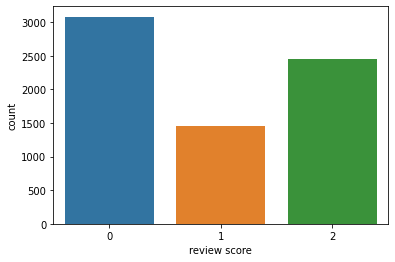

In [ ]:
sns.countplot(train_labels)
plt.xlabel('review score');

In [ ]:
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(val_input)
validation_labels = torch.tensor(val_labels)
validation_mask = torch.tensor(val_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)

## Model dan fuction

In [ ]:
def Train_Dataloader(train_input, train_mask, train_labels, batch_size):
  train_data = TensorDataset(train_input, train_mask, train_labels)
  train_sampler = RandomSampler(train_data)
  return DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

def Validation_Dataloader(validation_input, validation_mask, validation_labels, batch_size):
  validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
  validation_sampler = SequentialSampler(validation_data)
  return DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

def Test_Dataloader(test_input, test_mask, test_labels, batch_size):
  test_data = TensorDataset(test_input, test_mask, test_labels)
  test_sampler = SequentialSampler(test_data)
  return DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
class Model_bert(nn.Module):
  def __init__(self,checkpoint,num_labels): 
    super(Model_bert,self).__init__() 
    self.checkpoint = checkpoint
    self.num_labels = num_labels 

    #Load Model with given checkpoint and extract its body
    self.model = AutoModel.from_pretrained(checkpoint,config=AutoConfig.from_pretrained(checkpoint, output_attentions=True,output_hidden_states=True))
    self.linear = nn.Linear(768,num_labels) # load and initialize weights
    self.softmax = nn.Softmax(dim=1)
    self.loss = nn.CrossEntropyLoss()

  def forward(self, input_ids=None, attention_mask=None,labels=None):
    #Extract outputs from the body
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
    sequence_output = outputs[0] #outputs[0]=last hidden state
    output = self.linear(sequence_output[:,0,:].view(-1,768)) # calculate losses
    logits = self.softmax(output)

    loss = None
    if labels is not None:
      loss = self.loss(logits.view(-1, self.num_labels), labels.view(-1))
    
    return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [ ]:
def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def training(model, dataloader, optimizer, scheduler, training_stats, epochs):
  # capture time
  t0 = time.time()

  # Perform one full pass over the training set.
  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
  print('Running Train...')

  # reset total loss for epoch
  total_train_f1 = 0
  total_train_accuracy = 0
  total_train_loss = 0

  # put model into training mode
  model.train()
  for step, batch in enumerate(dataloader):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    optimizer.zero_grad()

    output = model(input_ids=b_input_ids, 
                         attention_mask=b_input_mask, 
                         labels=b_labels)
    loss = output.loss
    logits = output.logits

    total_train_loss += loss.item()
    
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

    logits = logits.detach().cpu().numpy()
    y_true = b_labels.detach().cpu().numpy()

    rounded_preds = np.argmax(logits, axis=1).flatten()
    
    # calculate f1
    total_train_f1 += f1_score(y_true, rounded_preds,
                                   average='weighted',
                                   labels=np.unique(rounded_preds))
    # calculate accuracy
    total_train_accuracy += accuracy_score(y_true, rounded_preds)

  # report final accuracy of training run
  avg_train_accuracy = total_train_accuracy / len(dataloader)

  # report final f1 of training run
  avg_train_f1 = total_train_f1 / len(dataloader)

  # calculate the average loss over all of the batches.
  avg_train_loss = total_train_loss / len(dataloader)

  training_stats.append(
      {
          'Train Loss': avg_train_loss,
          'Train F1': avg_train_f1,
          'Train Accuracy': avg_train_accuracy
      }
  )

  # training time end
  training_time = format_time(time.time() - t0)

  # print result summaries
  print("")
  print("summary results")
  print("epoch | trn loss | trn f1 | trn time | trn acc ")
  print(f"{epoch+1:5d} | {avg_train_loss:.2f} | {avg_train_f1:.2f} | {training_time:} | {avg_train_accuracy:.2f}")

  torch.cuda.empty_cache()

  return None

In [ ]:
def validating(model, dataloader, valid_stats):

  # capture validation time
  t0 = time.time()

  # After the completion of each training epoch, measure our performance on
  # our validation set.
  print("")
  print("Running Validation...")

  # put the model in evaluation mode
  model.eval()

  # track variables
  total_valid_accuracy = 0
  total_valid_loss = 0
  total_valid_f1 = 0
  total_valid_recall = 0
  total_valid_precision = 0

  # evaluate data for one epoch
  for batch in dataloader:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # tell pytorch not to bother calculating gradients
    # as its only necessary for training
    with torch.no_grad():

      # forward propagation (evaluate model on training batch)
      output = model(input_ids=b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)
      loss = output.loss
      logits = output.logits
    # accumulate validation loss
    total_valid_loss += loss.item()

    # move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    y_true = b_labels.detach().cpu().numpy()

    # calculate preds
    rounded_preds = np.argmax(logits, axis=1).flatten()

    # calculate f1
    total_valid_f1 += f1_score(y_true, rounded_preds,
                                average='weighted',
                                labels=np.unique(rounded_preds))

    # calculate accuracy
    total_valid_accuracy += accuracy_score(y_true, rounded_preds)

    # calculate precision
    total_valid_precision += precision_score(y_true, rounded_preds,
                                              average='weighted',
                                              labels=np.unique(rounded_preds))

    # calculate recall
    total_valid_recall += recall_score(y_true, rounded_preds,
                                              average='weighted',
                                              labels=np.unique(rounded_preds))

  # report final accuracy of validation run
  avg_accuracy = total_valid_accuracy / len(dataloader)

  # report final f1 of validation run
  global avg_val_f1
  avg_val_f1 = total_valid_f1 / len(dataloader)

  # report final precision of validation run
  avg_precision = total_valid_precision / len(dataloader)

  # report final recall of validation run
  avg_recall = total_valid_recall / len(dataloader)

  # calculate the average loss over all of the batches.
  global avg_val_loss
  avg_val_loss = total_valid_loss / len(dataloader)

  # Record all statistics from this epoch.
  valid_stats.append(
      {
          'Val Loss': avg_val_loss,
          'Val Accur.': avg_accuracy,
          'Val precision': avg_precision,
          'Val recall': avg_recall,
          'Val F1': avg_val_f1
      }
  )

  # capture end validation time
  training_time = format_time(time.time() - t0)

  # print result summaries
  print("")
  print("summary results")
  print("epoch | val loss | val f1 | val time")
  print(f"{epoch+1:5d} | {avg_val_loss:.5f} | {avg_val_f1:.5f} | {training_time:}")

  return None

In [ ]:
def testing(model, dataloader, test_stats):

  print("")
  print("Running Testing...")

  # put the model in evaluation mode
  model.eval()

  # track variables
  total_test_accuracy = 0
  total_test_loss = 0
  total_test_f1 = 0
  total_test_recall = 0
  total_test_precision = 0
  prediction, true_labels = [], []

  # evaluate data for one epoch
  for batch in dataloader:

      b_input_ids = batch[0].cuda()
      b_input_mask = batch[1].cuda()
      b_labels = batch[2].cuda().long()

      # tell pytorch not to bother calculating gradients
      # as its only necessary for training
      with torch.no_grad():

          # forward propagation (evaluate model on training batch)
          output = model(input_ids=b_input_ids,
                                attention_mask=b_input_mask,
                                labels=b_labels)
          loss= output.loss
          logits = output.logits

      # accumulate validation loss
      total_test_loss += loss.item()

      # move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      y_true = b_labels.detach().cpu().numpy()

      prediction.append(logits)
      true_labels.append(y_true)

      # calculate preds
      rounded_preds = np.argmax(logits, axis=1).flatten()

      # calculate f1
      total_test_f1 += f1_score(y_true, rounded_preds,
                                  average='weighted',
                                  labels=np.unique(rounded_preds))

      # calculate accuracy
      total_test_accuracy += accuracy_score(y_true, rounded_preds)

      # calculate precision
      total_test_precision += precision_score(y_true, rounded_preds,
                                                average='weighted',
                                                labels=np.unique(rounded_preds))

      # calculate recall
      total_test_recall += recall_score(y_true, rounded_preds,
                                                average='weighted',
                                                labels=np.unique(rounded_preds))
  
  flat_prediction = [item for sublist in prediction for item in sublist]
  flat_prediction = np.argmax(flat_prediction, axis=1).flatten()

  flat_true_labels = [item for sublist in true_labels for item in sublist]

  # report final accuracy
  avg_accuracy = total_test_accuracy / len(dataloader)

  # report final f1
  avg_test_f1 = total_test_f1 / len(dataloader)

  # report final precision
  avg_precision = total_test_precision / len(dataloader)

  # report final recall
  avg_recall = total_test_recall / len(dataloader)

  # calculate the average loss over all of the batches.
  avg_test_loss = total_test_loss / len(dataloader)

  # Record all statistics from this epoch.
  print(confusion_matrix(flat_true_labels, flat_prediction))
  print(classification_report(flat_true_labels, flat_prediction))
  test_stats.append(
      {
          'Test Loss': avg_test_loss,
          'Test Accur.': avg_accuracy,
          'Test precision': avg_precision,
          'Test recall': avg_recall,
          'Test F1': avg_test_f1
      }
  )
  return None

In [ ]:
def plot_results(df_stats, epochs):
    # styling from seaborn.
    sns.set(style='darkgrid')
    # uncrease the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # plot the learning curve.
    plt.plot(df_stats['Train Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Val Loss'], 'g-o', label="Validation")

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks(list(range(1, epochs+1)))
    return plt.show()

In [ ]:
def plot_F1(df_stats, epochs):
    # styling from seaborn.
    sns.set(style='darkgrid')
    # uncrease the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # plot the learning curve.
    plt.plot(df_stats['Train F1'], 'b-o', label="Training")
    plt.plot(df_stats['Val F1'], 'g-o', label="Validation")

    # Label the plot.
    plt.title("Training & Validation F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1")
    plt.legend()
    plt.xticks(list(range(1, epochs+1)))
    return plt.show()

## batch_size = 16

### epoch = 10

#### learning_rate = 1e-5

In [ ]:
batch_size = 16
learning_rate = 1e-5
epochs = 10
checkpoint = "indobenchmark/indobert-base-p1"

In [ ]:
train_dataloader = Train_Dataloader(train_input, train_mask, train_labels, batch_size)
validation_dataloader = Validation_Dataloader(validation_input, validation_mask, validation_labels, batch_size)
test_dataloader = Test_Dataloader(test_input, test_mask, test_labels, batch_size)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model= Model_bert(checkpoint=checkpoint,num_labels=3).to(device)
model.cuda()

Model_bert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [ ]:
optimizer = AdamW(model.parameters(), lr=learning_rate)

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
seed_val = 15

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats = []
valid_stats = []
best_valid_F1 = float('-inf')

# for each epoch
for epoch in range(epochs):
    # train
    training(model, train_dataloader, optimizer, scheduler, training_stats,epochs)
    validating(model, validation_dataloader, valid_stats)
    
    print("========== Saving =============")
    if valid_stats[epoch]['Val F1'] > best_valid_F1:
      best_valid_F1 = valid_stats[epoch]['Val F1']
      # save best model for use later
      print("saving")
      torch.save(model.state_dict(), 'bertweet-model.pt')  # torch save
      tokenizer.save_pretrained('./model_save/')  # transformers save


======== Epoch 1 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    1 | 0.83 | 0.72 | 0:01:45 | 0.71

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    1 | 0.82471 | 0.71524 | 0:00:07
========== Saving =============
saving

======== Epoch 2 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    2 | 0.75 | 0.79 | 0:01:45 | 0.79

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
    2 | 0.81496 | 0.72072 | 0:00:07
========== Saving =============
saving

======== Epoch 3 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    3 | 0.71 | 0.84 | 0:01:45 | 0.84

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    3 | 0.79429 | 0.75099 | 0:00:07
========== Saving =============
saving

======== Epoch 4 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    4 | 0.68 | 0.87 | 0:01:45 | 0.87

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
    4 | 0.80035 | 0.74287 | 0:00:07
========== Saving =============

======== Epoch 5 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    5 | 0.65 | 0.90 | 0:01:45 | 0.90

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    5 | 0.79561 | 0.75416 | 0:00:07
========== Saving =============
saving

======== Epoch 6 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    6 | 0.64 | 0.91 | 0:01:45 | 0.91

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    6 | 0.79810 | 0.74826 | 0:00:07
========== Saving =============

======== Epoch 7 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    7 | 0.63 | 0.92 | 0:01:45 | 0.92

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    7 | 0.79465 | 0.75681 | 0:00:07
========== Saving =============
saving

======== Epoch 8 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    8 | 0.62 | 0.93 | 0:01:45 | 0.93

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    8 | 0.79512 | 0.75346 | 0:00:07
========== Saving =============

======== Epoch 9 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    9 | 0.62 | 0.93 | 0:01:45 | 0.93

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    9 | 0.79275 | 0.75612 | 0:00:07
========== Saving =============

======== Epoch 10 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   10 | 0.62 | 0.93 | 0:01:45 | 0.93

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   10 | 0.79386 | 0.75521 | 0:00:07
========== Saving =============


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pd.set_option('precision', 3)
df_train_stats = pd.DataFrame(data=training_stats)
df_valid_stats = pd.DataFrame(data=valid_stats)
df_stats = pd.concat([df_train_stats, df_valid_stats], axis=1)
df_stats.insert(0, 'Epoch', range(1, len(df_stats)+1))
df_stats = df_stats.set_index('Epoch')
df_stats

,Train Loss,Train F1,Train Accuracy,Val Loss,Val Accur.,Val precision,Val recall,Val F1
Epoch,,,,,,,,
1,0.831,0.717,0.709,0.825,0.721,0.775,0.725,0.715
2,0.753,0.792,0.794,0.815,0.727,0.775,0.741,0.721
3,0.709,0.838,0.839,0.794,0.748,0.789,0.748,0.751
4,0.677,0.871,0.872,0.800,0.741,0.779,0.741,0.743
5,0.652,0.898,0.899,0.796,0.754,0.793,0.754,0.754
6,0.638,0.913,0.913,0.798,0.746,0.787,0.746,0.748
7,0.629,0.922,0.922,0.795,0.756,0.793,0.756,0.757
8,0.623,0.928,0.928,0.795,0.753,0.788,0.753,0.753
9,0.619,0.932,0.932,0.793,0.755,0.791,0.755,0.756


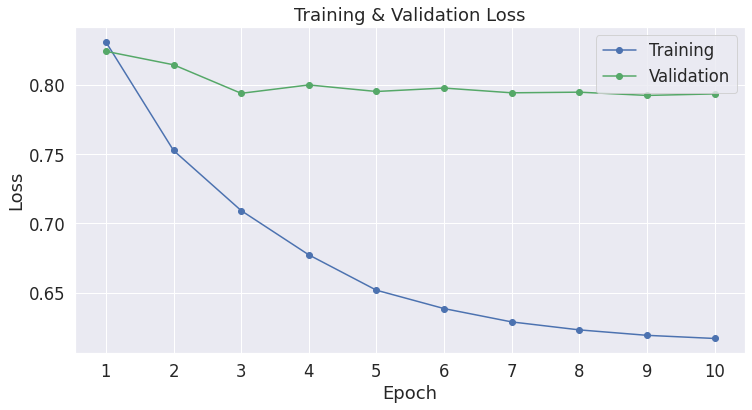

In [ ]:
plot_results(df_stats,epochs)

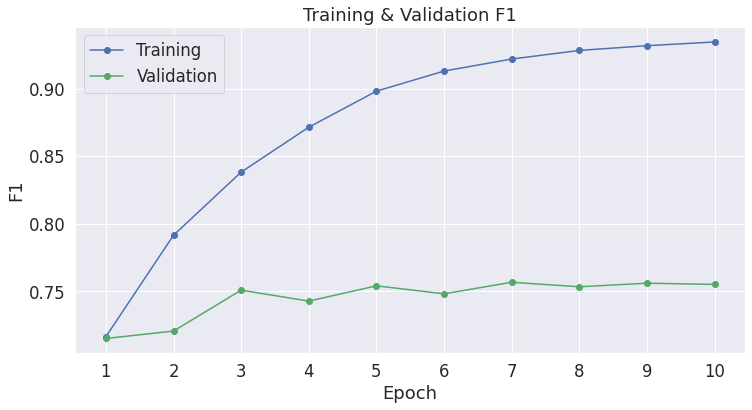

In [ ]:
plot_F1(df_stats,epochs)

In [ ]:
test_stats = []
model.load_state_dict(torch.load('bertweet-model.pt'))
testing(model, test_dataloader, test_stats)


Running Testing...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[570  59  32]
 [ 68 189  55]
 [ 68  43 416]]
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       661
           1       0.65      0.61      0.63       312
           2       0.83      0.79      0.81       527

    accuracy                           0.78      1500
   macro avg       0.76      0.75      0.76      1500
weighted avg       0.78      0.78      0.78      1500



In [ ]:
df_test_stats = pd.DataFrame(data=test_stats)
df_test_stats  

,Test Loss,Test Accur.,Test precision,Test recall,Test F1
0,0.765,0.783,0.82,0.786,0.786


#### learning_rate = 2e-5

In [ ]:
batch_size1 = 16
learning_rate1 = 2e-5
epochs1 = 10
checkpoint = "indobenchmark/indobert-base-p1"

In [ ]:
train_dataloader1 = Train_Dataloader(train_input, train_mask, train_labels, batch_size1)
validation_dataloader1 = Validation_Dataloader(validation_input, validation_mask, validation_labels, batch_size1)
test_dataloader1 = Test_Dataloader(test_input, test_mask, test_labels, batch_size1)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1= Model_bert(checkpoint=checkpoint,num_labels=3).to(device)
model1.cuda()

Model_bert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [ ]:
optimizer1 = AdamW(model1.parameters(), lr=learning_rate1)

total_steps1 = len(train_dataloader1) * epochs1

scheduler1 = get_linear_schedule_with_warmup(optimizer1, num_warmup_steps = 0, num_training_steps = total_steps1)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
seed_val = 15

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats1 = []
valid_stats1 = []
best_valid_F11= float('-inf')

# for each epoch
for epoch in range(epochs1):
    # train
    training(model1, train_dataloader1, optimizer1, scheduler1, training_stats1,epochs1)
    validating(model1, validation_dataloader1, valid_stats1)
    
    print("============= Saving ===============")
    if valid_stats1[epoch]['Val F1'] > best_valid_F11:
      best_valid_F11 = valid_stats1[epoch]['Val F1']
      # save best model for use later
      print("saving")
      torch.save(model1.state_dict(), 'bertweet-model1.pt')  # torch save
      tokenizer.save_pretrained('./model_save/')  # transformers save


======== Epoch 1 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    1 | 0.83 | 0.72 | 0:01:45 | 0.71

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    1 | 0.83023 | 0.71335 | 0:00:07
============= Saving ===============
saving

======== Epoch 2 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    2 | 0.76 | 0.79 | 0:01:45 | 0.79

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
    2 | 0.81807 | 0.72756 | 0:00:07
============= Saving ===============
saving

======== Epoch 3 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    3 | 0.72 | 0.83 | 0:01:45 | 0.83

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
    3 | 0.79889 | 0.74951 | 0:00:07
============= Saving ===============
saving

======== Epoch 4 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    4 | 0.68 | 0.87 | 0:01:45 | 0.87

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
    4 | 0.79667 | 0.75451 | 0:00:07
============= Saving ===============
saving

======== Epoch 5 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    5 | 0.66 | 0.89 | 0:01:45 | 0.89

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    5 | 0.80472 | 0.74033 | 0:00:07
============= Saving ===============

======== Epoch 6 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    6 | 0.65 | 0.91 | 0:01:45 | 0.91

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    6 | 0.79629 | 0.74792 | 0:00:07
============= Saving ===============

======== Epoch 7 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    7 | 0.64 | 0.91 | 0:01:45 | 0.91

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    7 | 0.81067 | 0.74353 | 0:00:07
============= Saving ===============

======== Epoch 8 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    8 | 0.63 | 0.92 | 0:01:45 | 0.92

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    8 | 0.81186 | 0.73543 | 0:00:07
============= Saving ===============

======== Epoch 9 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    9 | 0.62 | 0.93 | 0:01:45 | 0.93

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    9 | 0.80113 | 0.74290 | 0:00:07
============= Saving ===============

======== Epoch 10 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   10 | 0.62 | 0.93 | 0:01:45 | 0.93

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   10 | 0.79907 | 0.74704 | 0:00:07
============= Saving ===============


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pd.set_option('precision', 3)
df_train_stats1 = pd.DataFrame(data=training_stats1)
df_valid_stats1 = pd.DataFrame(data=valid_stats1)
df_stats1 = pd.concat([df_train_stats1, df_valid_stats1], axis=1)
df_stats1.insert(0, 'Epoch', range(1, len(df_stats1)+1))
df_stats1 = df_stats1.set_index('Epoch')
df_stats1

,Train Loss,Train F1,Train Accuracy,Val Loss,Val Accur.,Val precision,Val recall,Val F1
Epoch,,,,,,,,
1,0.832,0.716,0.712,0.830,0.710,0.762,0.710,0.713
2,0.757,0.790,0.790,0.818,0.727,0.768,0.745,0.728
3,0.715,0.831,0.831,0.799,0.751,0.785,0.753,0.750
4,0.682,0.865,0.867,0.797,0.752,0.790,0.755,0.755
5,0.660,0.891,0.890,0.805,0.739,0.780,0.739,0.740
6,0.646,0.905,0.906,0.796,0.749,0.783,0.752,0.748
7,0.636,0.914,0.915,0.811,0.740,0.784,0.740,0.744
8,0.629,0.921,0.922,0.812,0.734,0.776,0.734,0.735
9,0.624,0.927,0.927,0.801,0.745,0.781,0.745,0.743


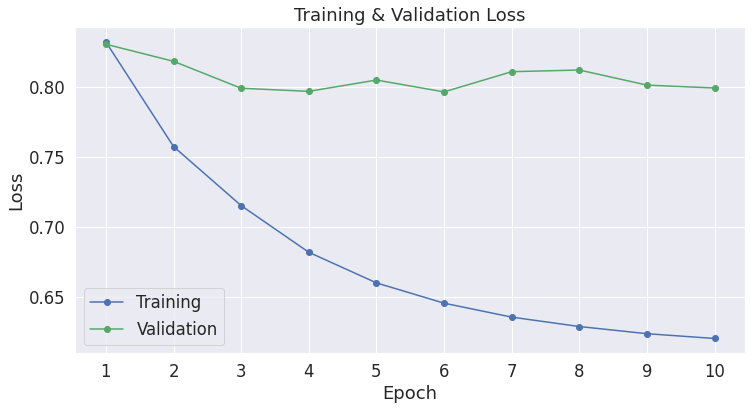

In [ ]:
plot_results(df_stats1,epochs1)

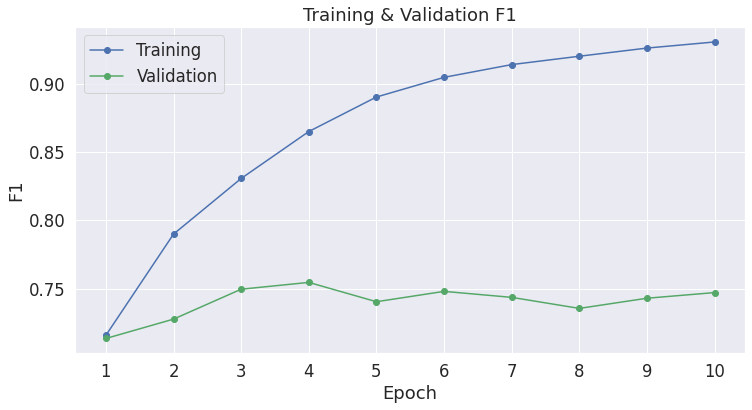

In [ ]:
plot_F1(df_stats1,epochs1)

In [ ]:
test_stats1 = []
model1.load_state_dict(torch.load('bertweet-model1.pt'))
testing(model1, test_dataloader1,test_stats1)


Running Testing...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[531  62  68]
 [ 54 185  73]
 [ 33  34 460]]
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       661
           1       0.66      0.59      0.62       312
           2       0.77      0.87      0.82       527

    accuracy                           0.78      1500
   macro avg       0.76      0.76      0.76      1500
weighted avg       0.78      0.78      0.78      1500



In [ ]:
df_test_stats1 = pd.DataFrame(data=test_stats1)
df_test_stats1 

,Test Loss,Test Accur.,Test precision,Test recall,Test F1
0,0.765,0.784,0.816,0.788,0.786


#### learning_rate = 3e-5

In [ ]:
batch_size2 = 16
learning_rate2 = 3e-5
epochs2 = 10
checkpoint = "indobenchmark/indobert-base-p1"

In [ ]:
train_dataloader2 = Train_Dataloader(train_input, train_mask, train_labels, batch_size2)
validation_dataloader2 = Validation_Dataloader(validation_input, validation_mask, validation_labels, batch_size2)
test_dataloader2 = Test_Dataloader(test_input, test_mask, test_labels, batch_size2)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2= Model_bert(checkpoint=checkpoint,num_labels=3).to(device)
model2.cuda()

Model_bert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [ ]:
optimizer2 = AdamW(model2.parameters(), lr=learning_rate2)

total_steps2 = len(train_dataloader2) * epochs2

scheduler2 = get_linear_schedule_with_warmup(optimizer2, num_warmup_steps = 0, num_training_steps = total_steps2)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
seed_val = 15

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats2 = []
valid_stats2 = []
best_valid_F12 = float('-inf')

# for each epoch
for epoch in range(epochs2):
    # train
    training(model2, train_dataloader2, optimizer2, scheduler2, training_stats2,epochs2)
    validating(model2, validation_dataloader2, valid_stats2)
    
    print("============== Saving ===================")
    if valid_stats2[epoch]['Val F1'] > best_valid_F12:
      best_valid_F12 = valid_stats2[epoch]['Val F1']
      # save best model for use later
      print("saving")
      torch.save(model2.state_dict(), 'bertweet-model2.pt')  # torch save
      tokenizer.save_pretrained('./model_save/')  # transformers save


======== Epoch 1 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    1 | 0.85 | 0.70 | 0:01:46 | 0.69

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    1 | 0.85221 | 0.68897 | 0:00:07
============== Saving ===================
saving

======== Epoch 2 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    2 | 0.79 | 0.76 | 0:01:45 | 0.76

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
    2 | 0.82765 | 0.73285 | 0:00:07
============== Saving ===================
saving

======== Epoch 3 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    3 | 0.75 | 0.79 | 0:01:45 | 0.80

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    3 | 0.81526 | 0.73358 | 0:00:07
============== Saving ===================
saving

======== Epoch 4 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    4 | 0.72 | 0.83 | 0:01:45 | 0.83

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    4 | 0.79874 | 0.74875 | 0:00:07
============== Saving ===================
saving

======== Epoch 5 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    5 | 0.70 | 0.86 | 0:01:45 | 0.85

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
    5 | 0.80995 | 0.73733 | 0:00:07
============== Saving ===================

======== Epoch 6 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    6 | 0.67 | 0.88 | 0:01:45 | 0.88

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    6 | 0.79900 | 0.74717 | 0:00:07
============== Saving ===================

======== Epoch 7 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    7 | 0.66 | 0.89 | 0:01:45 | 0.89

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    7 | 0.79439 | 0.75385 | 0:00:07
============== Saving ===================
saving

======== Epoch 8 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    8 | 0.65 | 0.90 | 0:01:45 | 0.90

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    8 | 0.80011 | 0.75223 | 0:00:07
============== Saving ===================

======== Epoch 9 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    9 | 0.64 | 0.91 | 0:01:45 | 0.91

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    9 | 0.79671 | 0.75004 | 0:00:07
============== Saving ===================

======== Epoch 10 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   10 | 0.64 | 0.91 | 0:01:45 | 0.91

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
   10 | 0.79820 | 0.74962 | 0:00:07
============== Saving ===================


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pd.set_option('precision', 3)
df_train_stats2 = pd.DataFrame(data=training_stats2)
df_valid_stats2 = pd.DataFrame(data=valid_stats2)
df_stats2 = pd.concat([df_train_stats2, df_valid_stats2], axis=1)
df_stats2.insert(0, 'Epoch', range(1, len(df_stats2)+1))
df_stats2 = df_stats2.set_index('Epoch')
df_stats2

,Train Loss,Train F1,Train Accuracy,Val Loss,Val Accur.,Val precision,Val recall,Val F1
Epoch,,,,,,,,
1,0.852,0.699,0.690,0.852,0.687,0.744,0.691,0.689
2,0.786,0.763,0.760,0.828,0.722,0.762,0.769,0.733
3,0.751,0.795,0.797,0.815,0.729,0.777,0.733,0.734
4,0.716,0.832,0.834,0.799,0.748,0.785,0.752,0.749
5,0.695,0.855,0.854,0.810,0.736,0.764,0.749,0.737
6,0.671,0.879,0.879,0.799,0.748,0.783,0.752,0.747
7,0.659,0.890,0.892,0.794,0.755,0.791,0.762,0.754
8,0.650,0.901,0.901,0.800,0.751,0.785,0.753,0.752
9,0.643,0.908,0.909,0.797,0.751,0.788,0.756,0.750


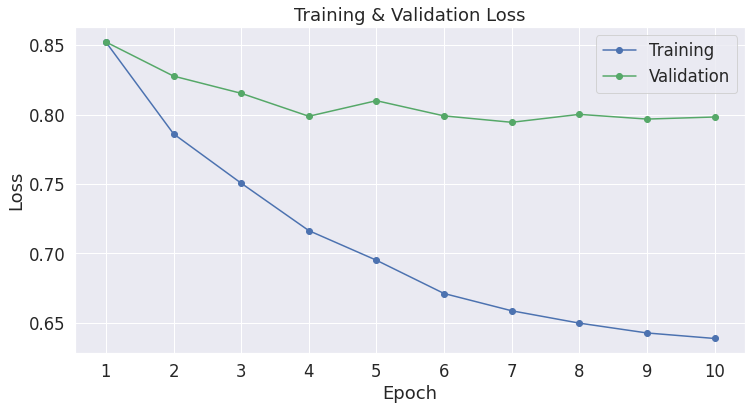

In [ ]:
plot_results(df_stats2,epochs2)

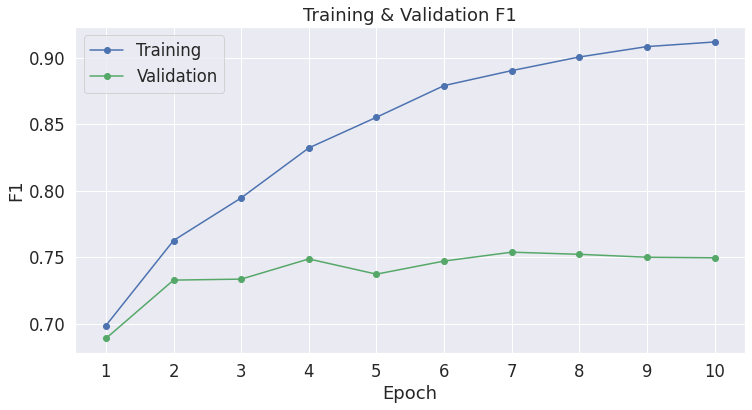

In [ ]:
plot_F1(df_stats2,epochs2)

In [ ]:
test_stats2 = []
model2.load_state_dict(torch.load('bertweet-model2.pt'))
testing(model2, test_dataloader2, test_stats2)


Running Testing...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[583  33  45]
 [ 95 151  66]
 [ 77  35 415]]
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       661
           1       0.69      0.48      0.57       312
           2       0.79      0.79      0.79       527

    accuracy                           0.77      1500
   macro avg       0.75      0.72      0.73      1500
weighted avg       0.76      0.77      0.76      1500



In [ ]:
df_test_stats2 = pd.DataFrame(data=test_stats2)
df_test_stats2 

,Test Loss,Test Accur.,Test precision,Test recall,Test F1
0,0.781,0.766,0.799,0.774,0.765


### epoch = 20

#### learning_rate = 1e-5

In [ ]:
batch_size3 = 16
learning_rate3 = 1e-5
epochs3 = 20
checkpoint = "indobenchmark/indobert-base-p1"

In [ ]:
train_dataloader3 = Train_Dataloader(train_input, train_mask, train_labels, batch_size3)
validation_dataloader3 = Validation_Dataloader(validation_input, validation_mask, validation_labels, batch_size3)
test_dataloader3 = Test_Dataloader(test_input, test_mask, test_labels, batch_size3)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3= Model_bert(checkpoint=checkpoint,num_labels=3).to(device)
model3.cuda()

Model_bert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [ ]:
optimizer3 = AdamW(model3.parameters(), lr=learning_rate3)

total_steps3 = len(train_dataloader3) * epochs3

scheduler3 = get_linear_schedule_with_warmup(optimizer3, num_warmup_steps = 0, num_training_steps = total_steps3)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
seed_val = 15

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats3 = []
valid_stats3 = []
best_valid_F13 = float('-inf')

# for each epoch
for epoch in range(epochs3):
    # train
    training(model3, train_dataloader3, optimizer3, scheduler3, training_stats3,epochs3)
    validating(model3, validation_dataloader3, valid_stats3)
    
    print("================ Saving ===================")
    if valid_stats3[epoch]['Val F1'] > best_valid_F13:
      best_valid_F13 = valid_stats3[epoch]['Val F1']
      # save best model for use later
      print("saving")
      torch.save(model3.state_dict(), 'bertweet-model3.pt')  # torch save
      tokenizer.save_pretrained('./model_save/')  # transformers save


======== Epoch 1 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    1 | 0.82 | 0.72 | 0:01:48 | 0.72

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    1 | 0.82396 | 0.71440 | 0:00:07
================ Saving ===================
saving

======== Epoch 2 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    2 | 0.75 | 0.80 | 0:01:45 | 0.80

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    2 | 0.80898 | 0.73512 | 0:00:07
================ Saving ===================
saving

======== Epoch 3 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    3 | 0.71 | 0.84 | 0:01:45 | 0.84

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    3 | 0.79853 | 0.74767 | 0:00:07
================ Saving ===================
saving

======== Epoch 4 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    4 | 0.68 | 0.87 | 0:01:45 | 0.87

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
    4 | 0.80092 | 0.74828 | 0:00:07
================ Saving ===================
saving

======== Epoch 5 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    5 | 0.65 | 0.90 | 0:01:45 | 0.90

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    5 | 0.80316 | 0.74382 | 0:00:07
================ Saving ===================

======== Epoch 6 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    6 | 0.64 | 0.91 | 0:01:45 | 0.91

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    6 | 0.80264 | 0.73772 | 0:00:07
================ Saving ===================

======== Epoch 7 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    7 | 0.63 | 0.92 | 0:01:45 | 0.92

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    7 | 0.80644 | 0.74535 | 0:00:07
================ Saving ===================

======== Epoch 8 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    8 | 0.62 | 0.93 | 0:01:45 | 0.93

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    8 | 0.80362 | 0.74136 | 0:00:07
================ Saving ===================

======== Epoch 9 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    9 | 0.62 | 0.93 | 0:01:45 | 0.93

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    9 | 0.80188 | 0.74327 | 0:00:07
================ Saving ===================

======== Epoch 10 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   10 | 0.62 | 0.94 | 0:01:46 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
   10 | 0.80514 | 0.74185 | 0:00:07
================ Saving ===================

======== Epoch 11 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   11 | 0.61 | 0.94 | 0:01:46 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   11 | 0.79641 | 0.75333 | 0:00:07
================ Saving ===================
saving

======== Epoch 12 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   12 | 0.61 | 0.94 | 0:01:45 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   12 | 0.80271 | 0.74474 | 0:00:07
================ Saving ===================

======== Epoch 13 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   13 | 0.61 | 0.94 | 0:01:45 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   13 | 0.80554 | 0.74671 | 0:00:07
================ Saving ===================

======== Epoch 14 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   14 | 0.61 | 0.94 | 0:01:45 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   14 | 0.80229 | 0.74670 | 0:00:07
================ Saving ===================

======== Epoch 15 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   15 | 0.61 | 0.94 | 0:01:45 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   15 | 0.81122 | 0.73799 | 0:00:07
================ Saving ===================

======== Epoch 16 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   16 | 0.61 | 0.94 | 0:01:45 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   16 | 0.80410 | 0.74251 | 0:00:07
================ Saving ===================

======== Epoch 17 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   17 | 0.61 | 0.94 | 0:01:45 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   17 | 0.80148 | 0.75170 | 0:00:07
================ Saving ===================

======== Epoch 18 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   18 | 0.61 | 0.94 | 0:01:45 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
   18 | 0.79684 | 0.75243 | 0:00:07
================ Saving ===================

======== Epoch 19 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   19 | 0.61 | 0.94 | 0:01:45 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
   19 | 0.79373 | 0.75832 | 0:00:07
================ Saving ===================
saving

======== Epoch 20 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   20 | 0.61 | 0.94 | 0:01:45 | 0.95

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
   20 | 0.79677 | 0.75128 | 0:00:07
================ Saving ===================


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pd.set_option('precision', 3)
df_train_stats3 = pd.DataFrame(data=training_stats3)
df_valid_stats3 = pd.DataFrame(data=valid_stats3)
df_stats3 = pd.concat([df_train_stats3, df_valid_stats3], axis=1)
df_stats3.insert(0, 'Epoch', range(1, len(df_stats3)+1))
df_stats3 = df_stats3.set_index('Epoch')
df_stats3

,Train Loss,Train F1,Train Accuracy,Val Loss,Val Accur.,Val precision,Val recall,Val F1
Epoch,,,,,,,,
1,0.824,0.723,0.717,0.824,0.721,0.770,0.726,0.714
2,0.747,0.796,0.799,0.809,0.737,0.769,0.745,0.735
3,0.706,0.841,0.843,0.799,0.745,0.788,0.746,0.748
4,0.677,0.870,0.872,0.801,0.743,0.786,0.743,0.748
5,0.655,0.895,0.896,0.803,0.744,0.778,0.747,0.744
6,0.641,0.909,0.910,0.803,0.742,0.775,0.749,0.738
7,0.632,0.917,0.918,0.806,0.741,0.777,0.746,0.745
8,0.624,0.927,0.928,0.804,0.743,0.778,0.743,0.741
9,0.618,0.933,0.933,0.802,0.744,0.777,0.747,0.743


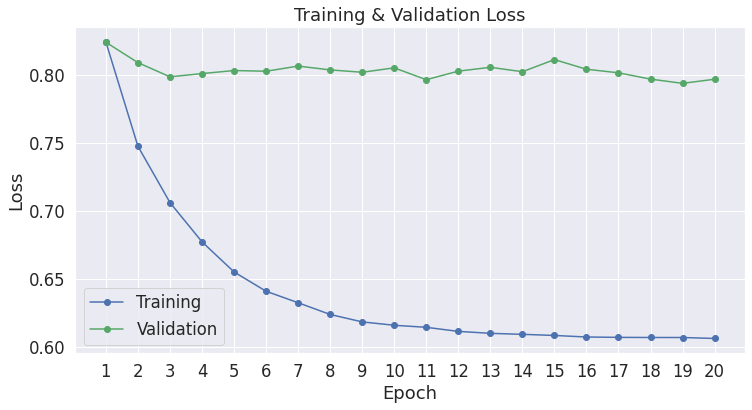

In [ ]:
plot_results(df_stats3,epochs3)

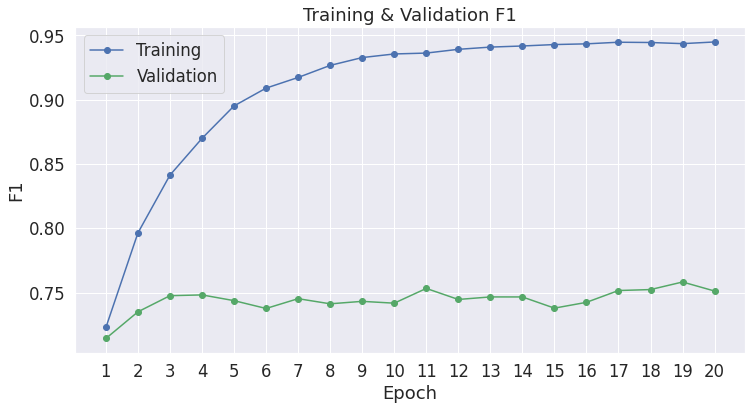

In [ ]:
plot_F1(df_stats3,epochs3)

In [ ]:
test_stats3 = []
model3.load_state_dict(torch.load('bertweet-model3.pt'))
testing(model3, test_dataloader3, test_stats3)


Running Testing...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[577  48  36]
 [ 73 174  65]
 [ 63  37 427]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       661
           1       0.67      0.56      0.61       312
           2       0.81      0.81      0.81       527

    accuracy                           0.79      1500
   macro avg       0.76      0.75      0.75      1500
weighted avg       0.78      0.79      0.78      1500



In [ ]:
df_test_stats3 = pd.DataFrame(data=test_stats3)
df_test_stats3 


,Test Loss,Test Accur.,Test precision,Test recall,Test F1
0,0.763,0.785,0.816,0.788,0.786


#### learning_rate = 2e-5

In [ ]:
batch_size4 = 16
learning_rate4 = 2e-5
epochs4 = 20
checkpoint = "indobenchmark/indobert-base-p1"

In [ ]:
train_dataloader4 = Train_Dataloader(train_input, train_mask, train_labels, batch_size4)
validation_dataloader4 = Validation_Dataloader(validation_input, validation_mask, validation_labels, batch_size4)
test_dataloader4 = Test_Dataloader(test_input, test_mask, test_labels, batch_size4) 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model4= Model_bert(checkpoint=checkpoint,num_labels=3).to(device)
model4.cuda()

Model_bert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [ ]:
optimizer4 = AdamW(model4.parameters(), lr=learning_rate4)

total_steps4 = len(train_dataloader4) * epochs4

scheduler4 = get_linear_schedule_with_warmup(optimizer4, num_warmup_steps = 0, num_training_steps = total_steps4)

In [ ]:
seed_val = 15

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats4 = []
valid_stats4 = []
best_valid_F14 = float('-inf')

# for each epoch
for epoch in range(epochs4):
    # train
    training(model4, train_dataloader4, optimizer4, scheduler4, training_stats4,epochs4)
    validating(model4, validation_dataloader4, valid_stats4)
    
    print("=========== Saving =============")
    if valid_stats4[epoch]['Val F1'] > best_valid_F14:
      best_valid_F14 = valid_stats4[epoch]['Val F1']
      # save best model for use later
      print("saving")
      torch.save(model4.state_dict(), 'bertweet-model4.pt')  # torch save
      tokenizer.save_pretrained('./model_save/')  # transformers save


======== Epoch 1 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    1 | 0.83 | 0.72 | 0:01:49 | 0.71

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
    1 | 0.83240 | 0.70504 | 0:00:07
=========== Saving =============
saving

======== Epoch 2 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    2 | 0.77 | 0.78 | 0:01:49 | 0.78

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
    2 | 0.80333 | 0.74352 | 0:00:07
=========== Saving =============
saving

======== Epoch 3 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    3 | 0.73 | 0.82 | 0:01:49 | 0.82

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    3 | 0.82463 | 0.72300 | 0:00:07
=========== Saving =============

======== Epoch 4 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    4 | 0.70 | 0.85 | 0:01:49 | 0.85

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    4 | 0.79675 | 0.74956 | 0:00:07
=========== Saving =============
saving

======== Epoch 5 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    5 | 0.67 | 0.88 | 0:01:49 | 0.88

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
    5 | 0.80490 | 0.74605 | 0:00:07
=========== Saving =============

======== Epoch 6 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    6 | 0.66 | 0.89 | 0:01:49 | 0.89

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    6 | 0.81246 | 0.73591 | 0:00:07
=========== Saving =============

======== Epoch 7 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    7 | 0.65 | 0.90 | 0:01:49 | 0.90

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    7 | 0.81127 | 0.73268 | 0:00:07
=========== Saving =============

======== Epoch 8 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    8 | 0.64 | 0.91 | 0:01:49 | 0.91

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    8 | 0.81559 | 0.73431 | 0:00:07
=========== Saving =============

======== Epoch 9 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    9 | 0.63 | 0.92 | 0:01:49 | 0.92

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    9 | 0.80145 | 0.74379 | 0:00:07
=========== Saving =============

======== Epoch 10 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   10 | 0.63 | 0.92 | 0:01:49 | 0.92

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   10 | 0.80199 | 0.74698 | 0:00:07
=========== Saving =============

======== Epoch 11 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   11 | 0.62 | 0.93 | 0:01:49 | 0.93

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   11 | 0.81527 | 0.74070 | 0:00:07
=========== Saving =============

======== Epoch 12 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   12 | 0.62 | 0.93 | 0:01:49 | 0.93

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   12 | 0.80045 | 0.75202 | 0:00:07
=========== Saving =============
saving

======== Epoch 13 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   13 | 0.61 | 0.94 | 0:01:49 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   13 | 0.80007 | 0.74878 | 0:00:07
=========== Saving =============

======== Epoch 14 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   14 | 0.61 | 0.94 | 0:01:49 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   14 | 0.79436 | 0.75131 | 0:00:07
=========== Saving =============

======== Epoch 15 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   15 | 0.61 | 0.94 | 0:01:49 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   15 | 0.79377 | 0.75486 | 0:00:07
=========== Saving =============
saving

======== Epoch 16 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   16 | 0.61 | 0.94 | 0:01:49 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   16 | 0.79505 | 0.75203 | 0:00:07
=========== Saving =============

======== Epoch 17 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   17 | 0.61 | 0.94 | 0:01:49 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   17 | 0.80180 | 0.75019 | 0:00:07
=========== Saving =============

======== Epoch 18 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   18 | 0.61 | 0.94 | 0:01:48 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   18 | 0.80277 | 0.74902 | 0:00:07
=========== Saving =============

======== Epoch 19 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   19 | 0.61 | 0.94 | 0:01:49 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   19 | 0.78831 | 0.75937 | 0:00:07
=========== Saving =============
saving

======== Epoch 20 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   20 | 0.61 | 0.94 | 0:01:49 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   20 | 0.78722 | 0.76025 | 0:00:07
=========== Saving =============
saving


In [ ]:
pd.set_option('precision', 3)
df_train_stats4 = pd.DataFrame(data=training_stats4)
df_valid_stats4 = pd.DataFrame(data=valid_stats4)
df_stats4 = pd.concat([df_train_stats4, df_valid_stats4], axis=1)
df_stats4.insert(0, 'Epoch', range(1, len(df_stats4)+1))
df_stats4 = df_stats4.set_index('Epoch')
df_stats4

,Train Loss,Train F1,Train Accuracy,Val Loss,Val Accur.,Val precision,Val recall,Val F1
Epoch,,,,,,,,
1,0.832,0.716,0.712,0.832,0.710,0.761,0.715,0.705
2,0.767,0.779,0.779,0.803,0.745,0.776,0.753,0.744
3,0.725,0.823,0.823,0.825,0.718,0.763,0.718,0.723
4,0.698,0.850,0.851,0.797,0.749,0.789,0.751,0.750
5,0.672,0.878,0.878,0.805,0.743,0.782,0.764,0.746
6,0.657,0.893,0.894,0.812,0.735,0.774,0.735,0.736
7,0.646,0.904,0.904,0.811,0.735,0.779,0.738,0.733
8,0.639,0.910,0.911,0.816,0.733,0.781,0.733,0.734
9,0.630,0.920,0.921,0.801,0.746,0.786,0.747,0.744


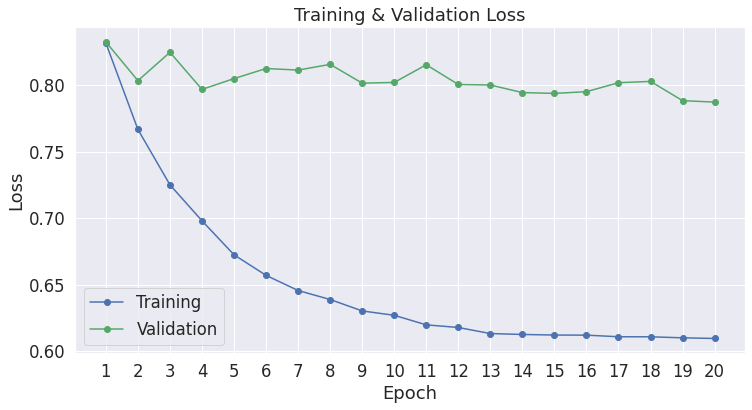

In [ ]:
plot_results(df_stats4,epochs4)

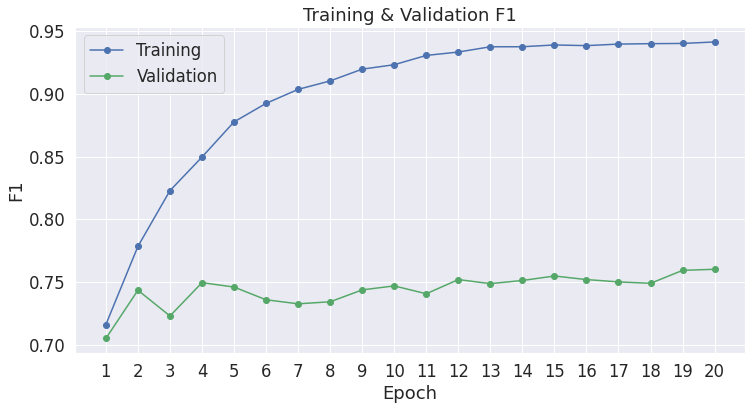

In [ ]:
plot_F1(df_stats4,epochs4)

In [ ]:
test_stats4 = []
model4.load_state_dict(torch.load('bertweet-model4.pt'))
testing(model4, test_dataloader4, test_stats4)


Running Testing...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[574  43  44]
 [ 80 169  63]
 [ 64  36 427]]
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       661
           1       0.68      0.54      0.60       312
           2       0.80      0.81      0.80       527

    accuracy                           0.78      1500
   macro avg       0.76      0.74      0.75      1500
weighted avg       0.77      0.78      0.78      1500



In [ ]:
df_test_stats4 = pd.DataFrame(data=test_stats4)
df_test_stats4

,Test Loss,Test Accur.,Test precision,Test recall,Test F1
0,0.769,0.78,0.813,0.786,0.781


#### learning_rate = 3e-5

In [ ]:
batch_size5 = 16
learning_rate5 = 3e-5 
epochs5 = 20
checkpoint = "indobenchmark/indobert-base-p1"

In [ ]:
train_dataloader5 = Train_Dataloader(train_input, train_mask, train_labels, batch_size5)
validation_dataloader5 = Validation_Dataloader(validation_input, validation_mask, validation_labels, batch_size5)
test_dataloader5 = Test_Dataloader(test_input, test_mask, test_labels, batch_size5)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model5= Model_bert(checkpoint=checkpoint,num_labels=3).to(device)
model5.cuda()

Model_bert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [ ]:
optimizer5 = AdamW(model5.parameters(), lr=learning_rate5)

total_steps5 = len(train_dataloader5) * epochs5

scheduler5 = get_linear_schedule_with_warmup(optimizer5, num_warmup_steps = 0, num_training_steps = total_steps5)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
seed_val = 15

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats5 = []
valid_stats5 = []
best_valid_F15 = float('-inf')

# for each epoch
for epoch in range(epochs5):
    # train
    training(model5, train_dataloader5, optimizer5, scheduler5, training_stats5,epochs5)
    validating(model5, validation_dataloader5, valid_stats5)
    
    print("=========== Saving =============")
    if valid_stats5[epoch]['Val F1'] > best_valid_F15:
      best_valid_F15 = valid_stats5[epoch]['Val F1']
      # save best model for use later
      print("saving")
      torch.save(model5.state_dict(), 'bertweet-model5.pt')  # torch save
      tokenizer.save_pretrained('./model_save/')  # transformers save


======== Epoch 1 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    1 | 0.84 | 0.70 | 0:01:49 | 0.70

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    1 | 0.89001 | 0.66857 | 0:00:07
=========== Saving =============
saving

======== Epoch 2 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    2 | 0.78 | 0.77 | 0:01:49 | 0.77

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
    2 | 0.82961 | 0.71796 | 0:00:07
=========== Saving =============
saving

======== Epoch 3 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    3 | 0.73 | 0.81 | 0:01:49 | 0.81

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    3 | 0.82407 | 0.72235 | 0:00:07
=========== Saving =============
saving

======== Epoch 4 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    4 | 0.70 | 0.85 | 0:01:49 | 0.85

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
    4 | 0.81246 | 0.73151 | 0:00:07
=========== Saving =============
saving

======== Epoch 5 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    5 | 0.69 | 0.86 | 0:01:49 | 0.86

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    5 | 0.82668 | 0.71376 | 0:00:07
=========== Saving =============

======== Epoch 6 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    6 | 0.67 | 0.88 | 0:01:49 | 0.88

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
    6 | 0.82277 | 0.72876 | 0:00:07
=========== Saving =============

======== Epoch 7 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    7 | 0.66 | 0.89 | 0:01:49 | 0.89

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
    7 | 0.82336 | 0.72277 | 0:00:07
=========== Saving =============

======== Epoch 8 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    8 | 0.65 | 0.90 | 0:01:49 | 0.91

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
    8 | 0.82382 | 0.72248 | 0:00:07
=========== Saving =============

======== Epoch 9 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    9 | 0.64 | 0.91 | 0:01:49 | 0.92

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
    9 | 0.81071 | 0.73824 | 0:00:07
=========== Saving =============
saving

======== Epoch 10 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   10 | 0.63 | 0.92 | 0:01:49 | 0.92

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   10 | 0.82032 | 0.73223 | 0:00:07
=========== Saving =============

======== Epoch 11 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   11 | 0.63 | 0.92 | 0:01:49 | 0.92

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
   11 | 0.82490 | 0.72206 | 0:00:07
=========== Saving =============

======== Epoch 12 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   12 | 0.63 | 0.92 | 0:01:49 | 0.93

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
   12 | 0.81942 | 0.73039 | 0:00:07
=========== Saving =============

======== Epoch 13 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   13 | 0.62 | 0.93 | 0:01:49 | 0.93

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
   13 | 0.81645 | 0.73591 | 0:00:07
=========== Saving =============

======== Epoch 14 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   14 | 0.62 | 0.93 | 0:01:49 | 0.93

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
   14 | 0.81820 | 0.73181 | 0:00:07
=========== Saving =============

======== Epoch 15 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   15 | 0.62 | 0.93 | 0:01:49 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
   15 | 0.81196 | 0.73993 | 0:00:07
=========== Saving =============
saving

======== Epoch 16 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   16 | 0.61 | 0.94 | 0:01:49 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   16 | 0.82482 | 0.72042 | 0:00:07
=========== Saving =============

======== Epoch 17 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   17 | 0.61 | 0.94 | 0:01:49 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   17 | 0.81465 | 0.73638 | 0:00:07
=========== Saving =============

======== Epoch 18 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   18 | 0.61 | 0.94 | 0:01:49 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 


summary results
epoch | val loss | val f1 | val time
   18 | 0.82035 | 0.73199 | 0:00:07
=========== Saving =============

======== Epoch 19 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   19 | 0.61 | 0.94 | 0:01:48 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
   19 | 0.81557 | 0.73558 | 0:00:07
=========== Saving =============

======== Epoch 20 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
   20 | 0.61 | 0.94 | 0:01:49 | 0.94

Running Validation...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



summary results
epoch | val loss | val f1 | val time
   20 | 0.81325 | 0.73843 | 0:00:07
=========== Saving =============


In [ ]:
pd.set_option('precision', 3)
df_train_stats5 = pd.DataFrame(data=training_stats5)
df_valid_stats5 = pd.DataFrame(data=valid_stats5)
df_stats5 = pd.concat([df_train_stats5, df_valid_stats5], axis=1)
df_stats5.insert(0, 'Epoch', range(1, len(df_stats5)+1))
df_stats5 = df_stats5.set_index('Epoch')
df_stats5

,Train Loss,Train F1,Train Accuracy,Val Loss,Val Accur.,Val precision,Val recall,Val F1
Epoch,,,,,,,,
1,0.844,0.700,0.698,0.890,0.649,0.768,0.649,0.669
2,0.778,0.767,0.765,0.830,0.715,0.753,0.737,0.718
3,0.735,0.812,0.813,0.824,0.719,0.762,0.720,0.722
4,0.702,0.845,0.847,0.812,0.730,0.769,0.733,0.732
5,0.686,0.863,0.864,0.827,0.719,0.752,0.722,0.714
6,0.668,0.882,0.883,0.823,0.725,0.771,0.725,0.729
7,0.657,0.891,0.892,0.823,0.723,0.762,0.726,0.723
8,0.646,0.905,0.905,0.824,0.722,0.759,0.727,0.722
9,0.635,0.914,0.915,0.811,0.738,0.782,0.738,0.738


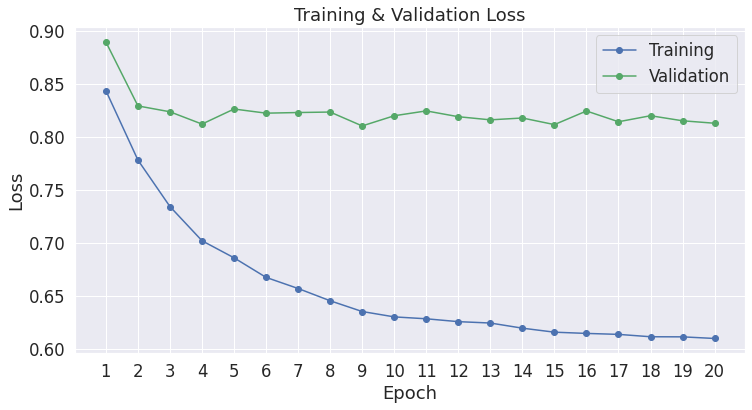

In [ ]:
plot_results(df_stats5,epochs5)

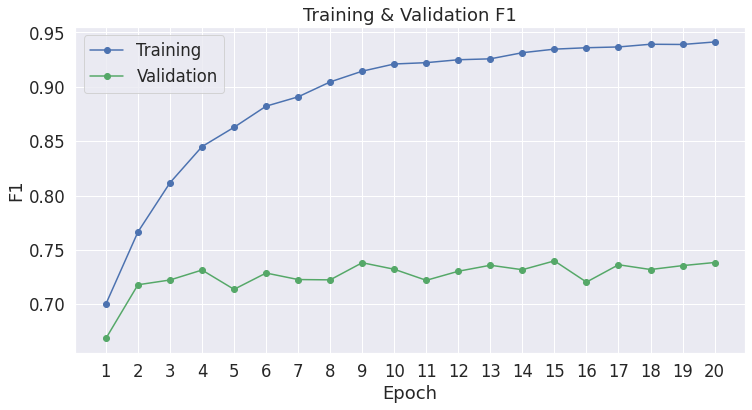

In [ ]:
plot_F1(df_stats5,epochs5)

In [ ]:
test_stats5 = []
model5.load_state_dict(torch.load('bertweet-model5.pt'))
testing(model5, test_dataloader5, test_stats5)


Running Testing...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[551  58  52]
 [ 65 185  62]
 [ 62  46 419]]
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       661
           1       0.64      0.59      0.62       312
           2       0.79      0.80      0.79       527

    accuracy                           0.77      1500
   macro avg       0.75      0.74      0.74      1500
weighted avg       0.77      0.77      0.77      1500



In [ ]:
df_test_stats5 = pd.DataFrame(data=test_stats5)
df_test_stats5  

,Test Loss,Test Accur.,Test precision,Test recall,Test F1
0,0.781,0.77,0.805,0.776,0.774


## batch_size = 32

### epoch = 10

#### learning_rate = 1e-5

In [ ]:
batch_size6 = 32
learning_rate6 = 1e-5 
epochs6 = 10
checkpoint = "indobenchmark/indobert-base-p1" 

In [ ]:
train_dataloader6 = Train_Dataloader(train_input, train_mask, train_labels, batch_size6)
validation_dataloader6 = Validation_Dataloader(validation_input, validation_mask, validation_labels, batch_size6)
test_dataloader6 = Test_Dataloader(test_input, test_mask, test_labels, batch_size6)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model6= Model_bert(checkpoint=checkpoint,num_labels=3).to(device)
model6.cuda()

Model_bert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [ ]:
optimizer6 = AdamW(model6.parameters(), lr=learning_rate6)

total_steps6 = len(train_dataloader6) * epochs6

scheduler6 = get_linear_schedule_with_warmup(optimizer6, num_warmup_steps = 0, num_training_steps = total_steps6)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
seed_val = 15

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats6 = []
valid_stats6 = []
best_valid_F16 = float('-inf')

# for each epoch
for epoch in range(epochs6):
    # train
    training(model6, train_dataloader6, optimizer6, scheduler6, training_stats6,epochs6)
    validating(model6, validation_dataloader6, valid_stats6)
    
    print("=========== Saving =============")
    if valid_stats6[epoch]['Val F1'] > best_valid_F16:
      best_valid_F16 = valid_stats6[epoch]['Val F1']
      # save best model for use later
      print("saving")
      torch.save(model6.state_dict(), 'bertweet-model6.pt')  # torch save
      tokenizer.save_pretrained('./model_save/')  # transformers save


======== Epoch 1 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    1 | 0.83 | 0.71 | 0:01:35 | 0.71

Running Validation...

summary results
epoch | val loss | val f1 | val time
    1 | 0.80978 | 0.73924 | 0:00:07
=========== Saving =============
saving

======== Epoch 2 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    2 | 0.76 | 0.78 | 0:01:34 | 0.79

Running Validation...

summary results
epoch | val loss | val f1 | val time
    2 | 0.79272 | 0.75349 | 0:00:07
=========== Saving =============
saving

======== Epoch 3 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    3 | 0.71 | 0.83 | 0:01:34 | 0.84

Running Validation...

summary results
epoch | val loss | val f1 | val time
    3 | 0.79302 | 0.73698 | 0:00:07
=========== Saving =============

======== Epoch 4 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | t

In [ ]:
pd.set_option('precision', 3)
df_train_stats6 = pd.DataFrame(data=training_stats6)
df_valid_stats6 = pd.DataFrame(data=valid_stats6)
df_stats6 = pd.concat([df_train_stats6, df_valid_stats6], axis=1)
df_stats6.insert(0, 'Epoch', range(1, len(df_stats6)+1))
df_stats6 = df_stats6.set_index('Epoch')
df_stats6

,Train Loss,Train F1,Train Accuracy,Val Loss,Val Accur.,Val precision,Val recall,Val F1
Epoch,,,,,,,,
1,0.835,0.705,0.709,0.810,0.739,0.764,0.739,0.739
2,0.756,0.783,0.791,0.793,0.757,0.777,0.757,0.753
3,0.713,0.834,0.838,0.793,0.746,0.757,0.746,0.737
4,0.684,0.864,0.867,0.795,0.747,0.765,0.747,0.745
5,0.663,0.885,0.888,0.795,0.751,0.770,0.751,0.750
6,0.647,0.903,0.905,0.795,0.753,0.775,0.753,0.755
7,0.637,0.913,0.915,0.790,0.759,0.773,0.759,0.754
8,0.631,0.920,0.921,0.789,0.758,0.773,0.758,0.758
9,0.626,0.924,0.926,0.793,0.753,0.768,0.753,0.751


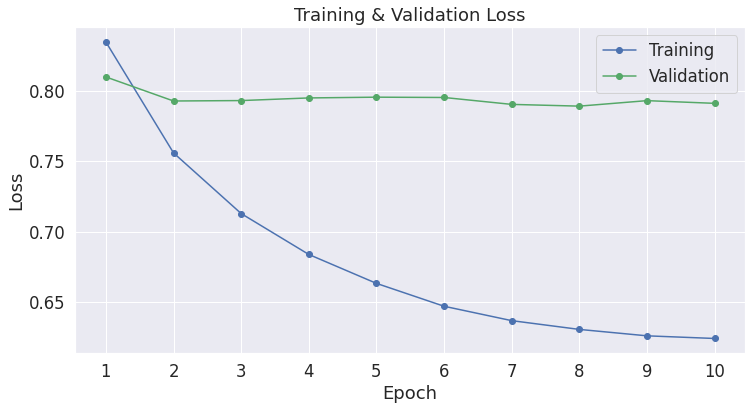

In [ ]:
plot_results(df_stats6,epochs6)

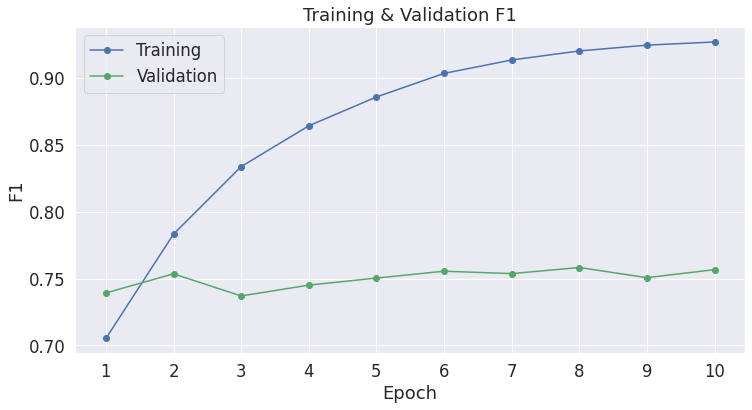

In [ ]:
plot_F1(df_stats6,epochs6)

In [ ]:
test_stats6 = []
model6.load_state_dict(torch.load('bertweet-model6.pt'))
testing(model6, test_dataloader6, test_stats6)


Running Testing...
[[560  58  43]
 [ 64 186  62]
 [ 52  43 432]]
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       661
           1       0.65      0.60      0.62       312
           2       0.80      0.82      0.81       527

    accuracy                           0.79      1500
   macro avg       0.76      0.75      0.76      1500
weighted avg       0.78      0.79      0.78      1500



In [ ]:
df_test_stats6 = pd.DataFrame(data=test_stats6)
df_test_stats6

,Test Loss,Test Accur.,Test precision,Test recall,Test F1
0,0.764,0.786,0.804,0.786,0.784


#### learning_rate = 2e-5

In [ ]:
batch_size7 = 32
learning_rate7 = 2e-5 
epochs7 = 10
checkpoint = "indobenchmark/indobert-base-p1"

In [ ]:
train_dataloader7 = Train_Dataloader(train_input, train_mask, train_labels, batch_size7)
validation_dataloader7 = Validation_Dataloader(validation_input, validation_mask, validation_labels, batch_size7)
test_dataloader7 = Test_Dataloader(test_input, test_mask, test_labels, batch_size7)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model7= Model_bert(checkpoint=checkpoint,num_labels=3).to(device)
model7.cuda()

Model_bert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [ ]:
optimizer7 = AdamW(model7.parameters(), lr=learning_rate7)

total_steps7 = len(train_dataloader7) * epochs7

scheduler7 = get_linear_schedule_with_warmup(optimizer7, num_warmup_steps = 0, num_training_steps = total_steps7)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
seed_val = 15

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats7 = []
valid_stats7 = []
best_valid_F17 = float('-inf')

# for each epoch
for epoch in range(epochs7):
    # train
    training(model7, train_dataloader7, optimizer7, scheduler7, training_stats7,epochs7)
    validating(model7, validation_dataloader7, valid_stats7)
    
    print("============ Saving =============")
    if valid_stats7[epoch]['Val F1'] > best_valid_F17:
      best_valid_F17 = valid_stats7[epoch]['Val F1']
      # save best model for use later
      print("saving")
      torch.save(model7.state_dict(), 'bertweet-model7.pt')  # torch save
      tokenizer.save_pretrained('./model_save/')  # transformers save


======== Epoch 1 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    1 | 0.83 | 0.70 | 0:01:32 | 0.70

Running Validation...

summary results
epoch | val loss | val f1 | val time
    1 | 0.83607 | 0.69602 | 0:00:06
============ Saving =============
saving

======== Epoch 2 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    2 | 0.75 | 0.79 | 0:01:31 | 0.79

Running Validation...

summary results
epoch | val loss | val f1 | val time
    2 | 0.79652 | 0.73301 | 0:00:06
============ Saving =============
saving

======== Epoch 3 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    3 | 0.71 | 0.84 | 0:01:31 | 0.84

Running Validation...

summary results
epoch | val loss | val f1 | val time
    3 | 0.81794 | 0.73300 | 0:00:06
============ Saving =============

======== Epoch 4 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 

In [ ]:
pd.set_option('precision', 3)
df_train_stats7 = pd.DataFrame(data=training_stats7)
df_valid_stats7 = pd.DataFrame(data=valid_stats7)
df_stats7 = pd.concat([df_train_stats7, df_valid_stats7], axis=1)
df_stats7.insert(0, 'Epoch', range(1, len(df_stats7)+1))
df_stats7 = df_stats7.set_index('Epoch')
df_stats7

,Train Loss,Train F1,Train Accuracy,Val Loss,Val Accur.,Val precision,Val recall,Val F1
Epoch,,,,,,,,
1,0.835,0.696,0.703,0.836,0.707,0.753,0.707,0.696
2,0.755,0.787,0.794,0.797,0.746,0.768,0.746,0.733
3,0.705,0.839,0.843,0.818,0.727,0.756,0.727,0.733
4,0.676,0.871,0.874,0.788,0.759,0.771,0.759,0.752
5,0.654,0.895,0.897,0.794,0.749,0.761,0.749,0.745
6,0.640,0.908,0.910,0.811,0.733,0.754,0.733,0.735
7,0.628,0.922,0.923,0.805,0.739,0.750,0.739,0.738
8,0.618,0.931,0.933,0.812,0.733,0.755,0.733,0.734
9,0.614,0.936,0.937,0.797,0.752,0.767,0.752,0.751


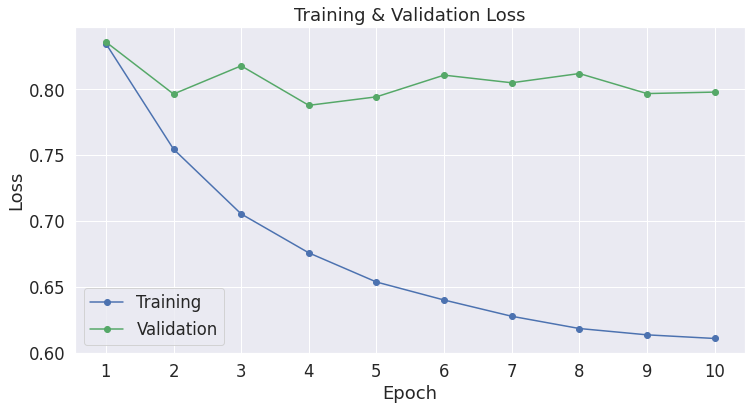

In [ ]:
plot_results(df_stats7,epochs7)

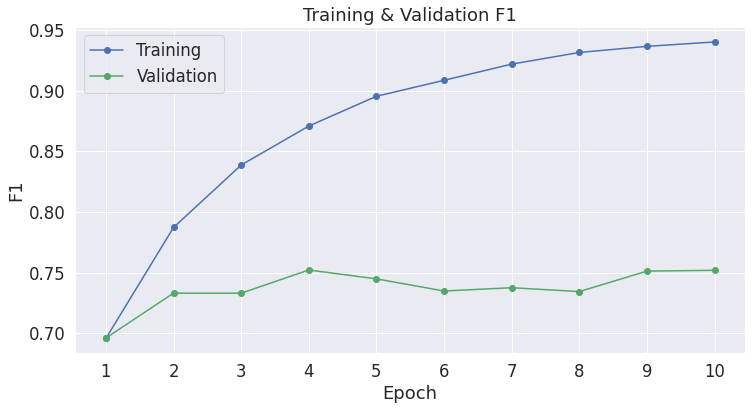

In [ ]:
plot_F1(df_stats7,epochs7)

In [ ]:
test_stats7 = []
model7.load_state_dict(torch.load('bertweet-model7.pt'))
testing(model7, test_dataloader7, test_stats7)


Running Testing...
[[570  38  53]
 [ 84 155  73]
 [ 57  19 451]]
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       661
           1       0.73      0.50      0.59       312
           2       0.78      0.86      0.82       527

    accuracy                           0.78      1500
   macro avg       0.77      0.74      0.75      1500
weighted avg       0.78      0.78      0.78      1500



In [ ]:
df_test_stats7 = pd.DataFrame(data=test_stats7)
df_test_stats7

,Test Loss,Test Accur.,Test precision,Test recall,Test F1
0,0.766,0.784,0.794,0.784,0.776


#### learning_rate = 3e-5

In [ ]:
batch_size8 = 32
learning_rate8 = 3e-5 
epochs8 = 10
checkpoint = "indobenchmark/indobert-base-p1"

In [ ]:
train_dataloader8 = Train_Dataloader(train_input, train_mask, train_labels, batch_size8)
validation_dataloader8 = Validation_Dataloader(validation_input, validation_mask, validation_labels, batch_size8)
test_dataloader8 = Test_Dataloader(test_input, test_mask, test_labels, batch_size8)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model8= Model_bert(checkpoint=checkpoint,num_labels=3).to(device)
model8.cuda()

Model_bert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [ ]:
optimizer8 = AdamW(model8.parameters(), lr=learning_rate8)

total_steps8 = len(train_dataloader8) * epochs8

scheduler8 = get_linear_schedule_with_warmup(optimizer8, num_warmup_steps = 0, num_training_steps = total_steps8)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
seed_val = 15

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats8 = []
valid_stats8 = []
best_valid_F18 = float('-inf')

# for each epoch
for epoch in range(epochs8):
    # train
    training(model8, train_dataloader8, optimizer8, scheduler8, training_stats8,epochs8)
    validating(model8, validation_dataloader8, valid_stats8)
    
    print("=========== Saving =============")
    if valid_stats8[epoch]['Val F1'] > best_valid_F18:
      best_valid_F18 = valid_stats8[epoch]['Val F1']
      # save best model for use later
      print("saving")
      torch.save(model8.state_dict(), 'bertweet-model8.pt')  # torch save
      tokenizer.save_pretrained('./model_save/')  # transformers save


======== Epoch 1 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    1 | 0.83 | 0.70 | 0:01:31 | 0.71

Running Validation...

summary results
epoch | val loss | val f1 | val time
    1 | 0.83012 | 0.70068 | 0:00:06
=========== Saving =============
saving

======== Epoch 2 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    2 | 0.77 | 0.77 | 0:01:31 | 0.78

Running Validation...

summary results
epoch | val loss | val f1 | val time
    2 | 0.81453 | 0.72448 | 0:00:06
=========== Saving =============
saving

======== Epoch 3 / 10 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    3 | 0.73 | 0.81 | 0:01:31 | 0.82

Running Validation...

summary results
epoch | val loss | val f1 | val time
    3 | 0.81072 | 0.72779 | 0:00:06
=========== Saving =============
saving

======== Epoch 4 / 10 ========
Running Train...

summary results
epoch | trn loss | trn

In [ ]:
pd.set_option('precision', 3)
df_train_stats8 = pd.DataFrame(data=training_stats8)
df_valid_stats8 = pd.DataFrame(data=valid_stats8)
df_stats8 = pd.concat([df_train_stats8, df_valid_stats8], axis=1)
df_stats8.insert(0, 'Epoch', range(1, len(df_stats8)+1))
df_stats8 = df_stats8.set_index('Epoch')
df_stats8

,Train Loss,Train F1,Train Accuracy,Val Loss,Val Accur.,Val precision,Val recall,Val F1
Epoch,,,,,,,,
1,0.834,0.704,0.710,0.830,0.710,0.744,0.710,0.701
2,0.769,0.773,0.779,0.815,0.731,0.745,0.731,0.724
3,0.728,0.815,0.819,0.811,0.735,0.756,0.735,0.728
4,0.692,0.855,0.858,0.800,0.744,0.761,0.744,0.744
5,0.663,0.885,0.887,0.803,0.741,0.761,0.741,0.741
6,0.650,0.900,0.901,0.803,0.747,0.758,0.747,0.740
7,0.635,0.914,0.915,0.808,0.737,0.749,0.737,0.735
8,0.626,0.924,0.925,0.808,0.740,0.753,0.740,0.739
9,0.620,0.930,0.931,0.805,0.741,0.758,0.741,0.739


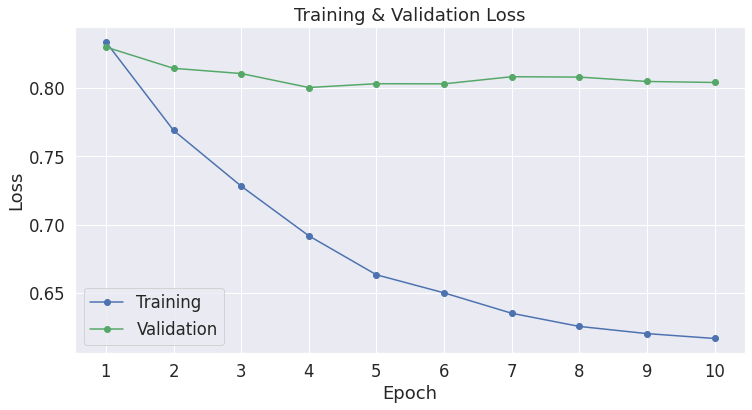

In [ ]:
plot_results(df_stats8,epochs8)

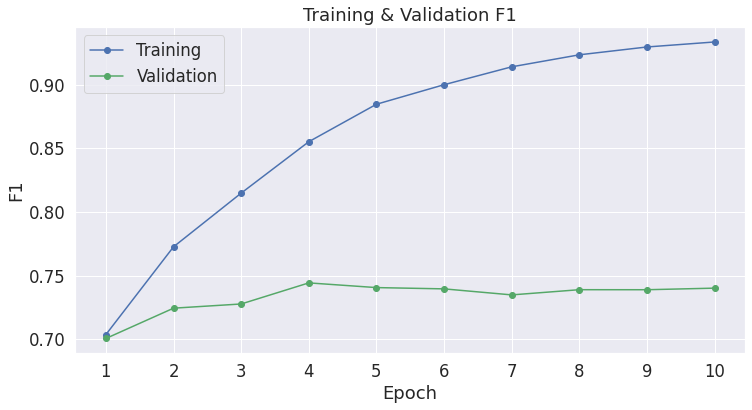

In [ ]:
plot_F1(df_stats8,epochs8)

In [ ]:
test_stats8 = []
model8.load_state_dict(torch.load('bertweet-model8.pt'))
testing(model8, test_dataloader8, test_stats8)


Running Testing...
[[514  81  66]
 [ 61 184  67]
 [ 43  49 435]]
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       661
           1       0.59      0.59      0.59       312
           2       0.77      0.83      0.79       527

    accuracy                           0.76      1500
   macro avg       0.73      0.73      0.73      1500
weighted avg       0.76      0.76      0.76      1500



In [ ]:
df_test_stats8 = pd.DataFrame(data=test_stats8)
df_test_stats8 

,Test Loss,Test Accur.,Test precision,Test recall,Test F1
0,0.792,0.755,0.773,0.755,0.756


### epoch = 20

#### learning_rate = 1e-5

In [ ]:
batch_size9 = 32
learning_rate9 = 1e-5
epochs9 = 20
checkpoint = "indobenchmark/indobert-base-p1"

In [ ]:
train_dataloader9 = Train_Dataloader(train_input, train_mask, train_labels, batch_size9)
validation_dataloader9 = Validation_Dataloader(validation_input, validation_mask, validation_labels, batch_size9)
test_dataloader9 = Test_Dataloader(test_input, test_mask, test_labels, batch_size9)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model9= Model_bert(checkpoint=checkpoint,num_labels=3).to(device)
model9.cuda()

Model_bert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [ ]:
optimizer9 = AdamW(model9.parameters(), lr=learning_rate9)

total_steps9 = len(train_dataloader9) * epochs9

scheduler9 = get_linear_schedule_with_warmup(optimizer9, num_warmup_steps = 0, num_training_steps = total_steps9)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
seed_val = 15

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats9 = []
valid_stats9 = []
best_valid_F19 = float('-inf')

# for each epoch
for epoch in range(epochs9):
    # train
    training(model9, train_dataloader9, optimizer9, scheduler9, training_stats9,epochs9)
    validating(model9, validation_dataloader9, valid_stats9)
    
    print("============ Saving =============")
    if valid_stats9[epoch]['Val F1'] > best_valid_F19:
      best_valid_F19 = valid_stats9[epoch]['Val F1']
      # save best model for use later
      print("saving")
      torch.save(model9.state_dict(), 'bertweet-model9.pt')  # torch save
      tokenizer.save_pretrained('./model_save/')  # transformers save


======== Epoch 1 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    1 | 0.83 | 0.71 | 0:01:27 | 0.71

Running Validation...

summary results
epoch | val loss | val f1 | val time
    1 | 0.82954 | 0.71616 | 0:00:06
============ Saving =============
saving

======== Epoch 2 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    2 | 0.76 | 0.78 | 0:01:29 | 0.79

Running Validation...

summary results
epoch | val loss | val f1 | val time
    2 | 0.80414 | 0.72745 | 0:00:06
============ Saving =============
saving

======== Epoch 3 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    3 | 0.72 | 0.83 | 0:01:31 | 0.83

Running Validation...

summary results
epoch | val loss | val f1 | val time
    3 | 0.79446 | 0.75426 | 0:00:06
============ Saving =============
saving

======== Epoch 4 / 20 ========
Running Train...

summary results
epoch | trn loss | 

In [ ]:
pd.set_option('precision', 3)
df_train_stats9 = pd.DataFrame(data=training_stats9)
df_valid_stats9 = pd.DataFrame(data=valid_stats9)
df_stats9 = pd.concat([df_train_stats9, df_valid_stats9], axis=1)
df_stats9.insert(0, 'Epoch', range(1, len(df_stats9)+1))
df_stats9 = df_stats9.set_index('Epoch')
df_stats9

,Train Loss,Train F1,Train Accuracy,Val Loss,Val Accur.,Val precision,Val recall,Val F1
Epoch,,,,,,,,
1,0.834,0.706,0.711,0.830,0.718,0.759,0.718,0.716
2,0.760,0.783,0.789,0.804,0.734,0.750,0.734,0.727
3,0.718,0.825,0.830,0.794,0.755,0.771,0.755,0.754
4,0.694,0.856,0.858,0.790,0.755,0.769,0.755,0.753
5,0.666,0.883,0.884,0.789,0.756,0.769,0.756,0.755
6,0.650,0.899,0.900,0.798,0.748,0.769,0.748,0.747
7,0.638,0.912,0.914,0.798,0.749,0.769,0.749,0.736
8,0.633,0.918,0.919,0.791,0.757,0.774,0.757,0.756
9,0.625,0.925,0.927,0.792,0.754,0.774,0.754,0.756


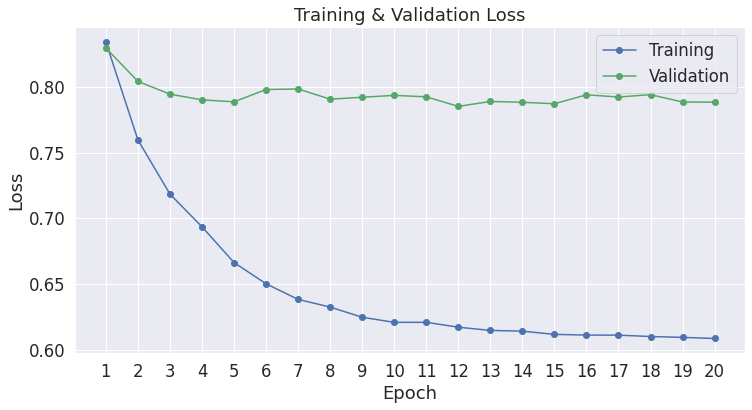

In [ ]:
plot_results(df_stats9,epochs9)

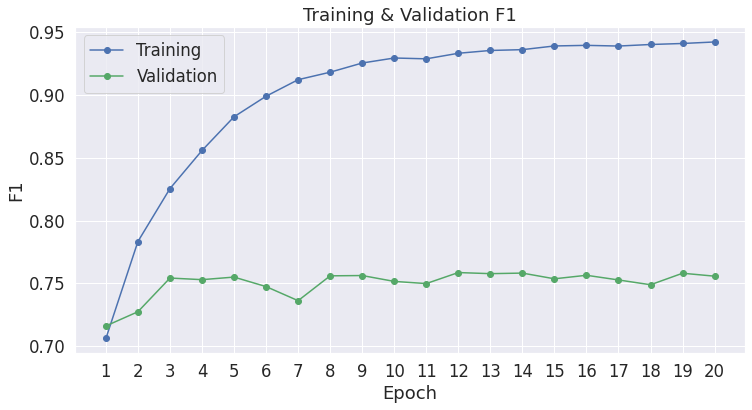

In [ ]:
plot_F1(df_stats9,epochs9)

In [ ]:
test_stats9 = []
model9.load_state_dict(torch.load('bertweet-model9.pt'))
testing(model9, test_dataloader9, test_stats9)


Running Testing...
[[571  37  53]
 [ 77 160  75]
 [ 56  30 441]]
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       661
           1       0.70      0.51      0.59       312
           2       0.78      0.84      0.80       527

    accuracy                           0.78      1500
   macro avg       0.76      0.74      0.75      1500
weighted avg       0.78      0.78      0.77      1500



In [ ]:
df_test_stats9 = pd.DataFrame(data=test_stats9)
df_test_stats9

,Test Loss,Test Accur.,Test precision,Test recall,Test F1
0,0.768,0.782,0.793,0.782,0.775


#### learning_rate = 2e-5

In [ ]:
batch_size10 = 32
learning_rate10 = 2e-5
epochs10 = 20
checkpoint = "indobenchmark/indobert-base-p1"

In [ ]:
train_dataloader10 = Train_Dataloader(train_input, train_mask, train_labels, batch_size10)
validation_dataloader10 = Validation_Dataloader(validation_input, validation_mask, validation_labels, batch_size10)
test_dataloader10 = Test_Dataloader(test_input, test_mask, test_labels, batch_size10)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model10= Model_bert(checkpoint=checkpoint,num_labels=3).to(device)
model10.cuda()

Model_bert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [ ]:
optimizer10 = AdamW(model10.parameters(), lr=learning_rate10)

total_steps10 = len(train_dataloader10) * epochs10

scheduler10 = get_linear_schedule_with_warmup(optimizer10, num_warmup_steps = 0, num_training_steps = total_steps10)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
seed_val = 15

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats10 = []
valid_stats10 = []
best_valid_F110= float('-inf')

# for each epoch
for epoch in range(epochs10):
    # train
    training(model10, train_dataloader10, optimizer10, scheduler10, training_stats10,epochs10)
    validating(model10, validation_dataloader10, valid_stats10)
    
    print("=========== Saving ============")
    if valid_stats10[epoch]['Val F1'] > best_valid_F110:
      best_valid_F110 = valid_stats10[epoch]['Val F1']
      # save best model for use later
      print("saving")
      torch.save(model10.state_dict(), 'bertweet-model10.pt')  # torch save
      tokenizer.save_pretrained('./model_save/')  # transformers save


======== Epoch 1 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    1 | 0.83 | 0.70 | 0:01:31 | 0.71

Running Validation...

summary results
epoch | val loss | val f1 | val time
    1 | 0.81998 | 0.70943 | 0:00:06
=========== Saving ============
saving

======== Epoch 2 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    2 | 0.76 | 0.78 | 0:01:31 | 0.79

Running Validation...

summary results
epoch | val loss | val f1 | val time
    2 | 0.81043 | 0.72229 | 0:00:06
=========== Saving ============
saving

======== Epoch 3 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    3 | 0.72 | 0.83 | 0:01:31 | 0.83

Running Validation...

summary results
epoch | val loss | val f1 | val time
    3 | 0.80584 | 0.73039 | 0:00:06
=========== Saving ============
saving

======== Epoch 4 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1

In [ ]:
pd.set_option('precision', 3)
df_train_stats10 = pd.DataFrame(data=training_stats10)
df_valid_stats10= pd.DataFrame(data=valid_stats10)
df_stats10 = pd.concat([df_train_stats10, df_valid_stats10], axis=1)
df_stats10.insert(0, 'Epoch', range(1, len(df_stats10)+1))
df_stats10 = df_stats10.set_index('Epoch')
df_stats10

,Train Loss,Train F1,Train Accuracy,Val Loss,Val Accur.,Val precision,Val recall,Val F1
Epoch,,,,,,,,
1,0.832,0.704,0.712,0.820,0.719,0.747,0.719,0.709
2,0.757,0.782,0.788,0.810,0.732,0.750,0.734,0.722
3,0.716,0.828,0.833,0.806,0.740,0.761,0.740,0.730
4,0.690,0.856,0.859,0.792,0.755,0.767,0.755,0.751
5,0.665,0.883,0.885,0.794,0.749,0.764,0.749,0.742
6,0.652,0.897,0.898,0.803,0.741,0.754,0.741,0.735
7,0.642,0.907,0.909,0.801,0.745,0.758,0.745,0.738
8,0.632,0.918,0.919,0.801,0.746,0.758,0.746,0.742
9,0.622,0.927,0.929,0.797,0.751,0.762,0.751,0.745


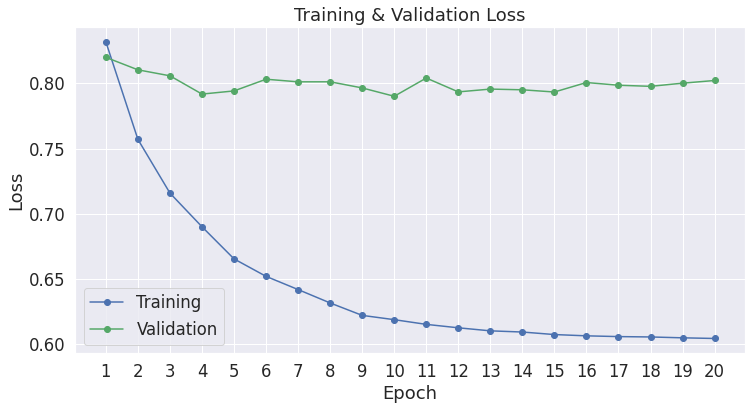

In [ ]:
plot_results(df_stats10,epochs10)

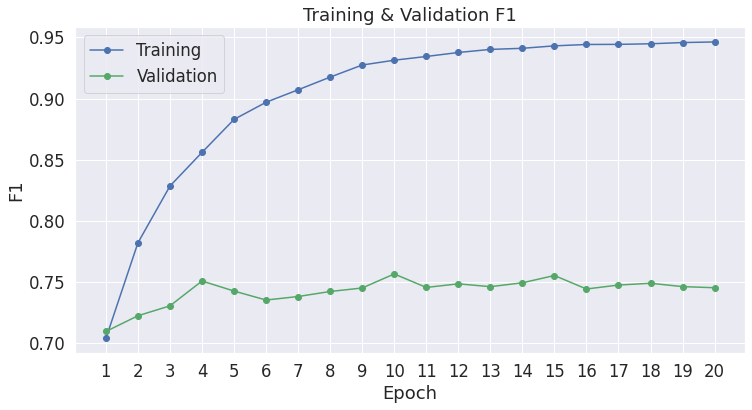

In [ ]:
plot_F1(df_stats10,epochs10)

In [ ]:
test_stats10 = []
model10.load_state_dict(torch.load('bertweet-model10.pt'))
testing(model10, test_dataloader10,test_stats10)


Running Testing...
[[569  59  33]
 [ 80 182  50]
 [ 64  55 408]]
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       661
           1       0.61      0.58      0.60       312
           2       0.83      0.77      0.80       527

    accuracy                           0.77      1500
   macro avg       0.75      0.74      0.74      1500
weighted avg       0.77      0.77      0.77      1500



In [ ]:
df_test_stats10 = pd.DataFrame(data=test_stats10)
df_test_stats10 

,Test Loss,Test Accur.,Test precision,Test recall,Test F1
0,0.775,0.773,0.787,0.773,0.77


#### learning_rate = 3e-5

In [ ]:
batch_size11 = 32
learning_rate11 = 3e-5
epochs11 = 20
checkpoint = "indobenchmark/indobert-base-p1"

In [ ]:
train_dataloader11 = Train_Dataloader(train_input, train_mask, train_labels, batch_size11)
validation_dataloader11 = Validation_Dataloader(validation_input, validation_mask, validation_labels, batch_size11)
test_dataloader11 = Test_Dataloader(test_input, test_mask, test_labels, batch_size11)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model11= Model_bert(checkpoint=checkpoint,num_labels=3).to(device)
model11.cuda()

Model_bert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [ ]:
optimizer11 = AdamW(model11.parameters(), lr=learning_rate11)

total_steps11 = len(train_dataloader11) * epochs11

scheduler11 = get_linear_schedule_with_warmup(optimizer11, num_warmup_steps = 0, num_training_steps = total_steps11)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
seed_val = 15

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats11 = []
valid_stats11 = []
best_valid_F111= float('-inf')

# for each epoch
for epoch in range(epochs11):
    # train
    training(model11, train_dataloader11, optimizer11, scheduler11, training_stats11,epochs11)
    validating(model11, validation_dataloader11, valid_stats11)
    
    print("========= Saving ==========")
    if valid_stats11[epoch]['Val F1'] > best_valid_F111:
      best_valid_F111 = valid_stats11[epoch]['Val F1']
      # save best model for use later
      print("saving")
      torch.save(model11.state_dict(), 'bertweet-model11.pt')  # torch save
      tokenizer.save_pretrained('./model_save/')  # transformers save


======== Epoch 1 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    1 | 0.83 | 0.71 | 0:01:34 | 0.72

Running Validation...

summary results
epoch | val loss | val f1 | val time
    1 | 0.82315 | 0.72214 | 0:00:06
========= Saving ==========
saving

======== Epoch 2 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    2 | 0.77 | 0.78 | 0:01:31 | 0.78

Running Validation...

summary results
epoch | val loss | val f1 | val time
    2 | 0.80780 | 0.73661 | 0:00:06
========= Saving ==========
saving

======== Epoch 3 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn acc 
    3 | 0.73 | 0.82 | 0:01:31 | 0.82

Running Validation...

summary results
epoch | val loss | val f1 | val time
    3 | 0.81021 | 0.72638 | 0:00:06
========= Saving ==========

======== Epoch 4 / 20 ========
Running Train...

summary results
epoch | trn loss | trn f1 | trn time | trn a

In [ ]:
pd.set_option('precision', 3)
df_train_stats11 = pd.DataFrame(data=training_stats11)
df_valid_stats11 = pd.DataFrame(data=valid_stats11)
df_stats11 = pd.concat([df_train_stats11, df_valid_stats11], axis=1)
df_stats11.insert(0, 'Epoch', range(1, len(df_stats11)+1))
df_stats11 = df_stats11.set_index('Epoch')
df_stats11

,Train Loss,Train F1,Train Accuracy,Val Loss,Val Accur.,Val precision,Val recall,Val F1
Epoch,,,,,,,,
1,0.825,0.706,0.715,0.823,0.719,0.758,0.719,0.722
2,0.767,0.776,0.780,0.808,0.737,0.759,0.737,0.737
3,0.727,0.815,0.820,0.810,0.732,0.743,0.732,0.726
4,0.703,0.843,0.846,0.815,0.732,0.748,0.732,0.724
5,0.679,0.869,0.871,0.801,0.739,0.754,0.739,0.733
6,0.664,0.884,0.886,0.825,0.721,0.753,0.721,0.726
7,0.649,0.900,0.902,0.793,0.756,0.772,0.756,0.755
8,0.640,0.909,0.910,0.790,0.758,0.771,0.758,0.755
9,0.626,0.924,0.925,0.801,0.744,0.759,0.744,0.740


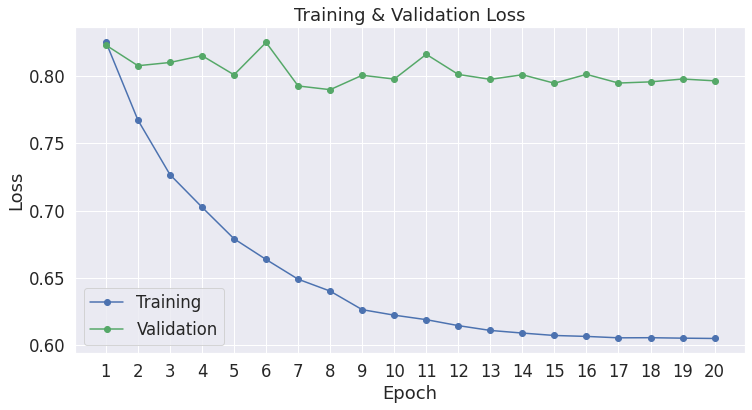

In [ ]:
plot_results(df_stats11, epochs11)

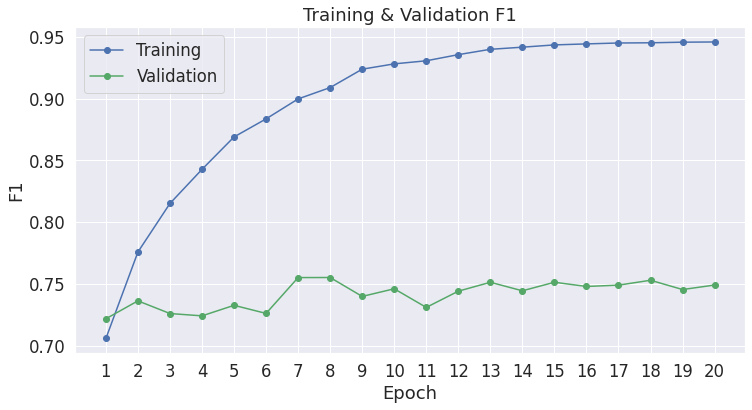

In [ ]:
plot_F1(df_stats11, epochs11)

In [ ]:
test_stats11 = []
model11.load_state_dict(torch.load('bertweet-model11.pt'))
testing(model11, test_dataloader11,test_stats11)


Running Testing...
[[582  39  40]
 [ 88 164  60]
 [ 61  44 422]]
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       661
           1       0.66      0.53      0.59       312
           2       0.81      0.80      0.80       527

    accuracy                           0.78      1500
   macro avg       0.76      0.74      0.74      1500
weighted avg       0.77      0.78      0.77      1500



In [ ]:
df_test_stats11 = pd.DataFrame(data=test_stats11)
df_test_stats11 

,Test Loss,Test Accur.,Test precision,Test recall,Test F1
0,0.768,0.779,0.792,0.779,0.773


# Nggak digunakan

In [ ]:
character = ['.',',',';',':','-,','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# hapus karakter yang berulang
def repeatcharClean(text): 
  for i in range(len(character)):
    charac_long = 5
    while charac_long > 2:
      char = character[i]*charac_long 
      text = text.replace(char,character[i])
      charac_long -= 1
  return text

def clean_review(text):
  # ubah text menjadi huruf kecil
  text = text.lower()
  # ubah enter menjadi spasi
  text = re.sub(r'\n', ' ', text)
  # hapus emoji
  #text = emoji.demojize(text)
  text = re.sub(':[A-Za-z_-]+:', ' ', text) # delete emoji
  # hapus emoticon
  text = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", ' ', text)
  # hapus link
  text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", text)
  # hapus usename
  text = re.sub(r"@[^\s]+[\s]?", ' ', text)
  # hapus hashtag
  text = re.sub(r'#(\S+)', r'\1', text)
  # hapus angka dan beberapa simbol
  text = re.sub('[^a-zA-Z,.?!]+',' ',text)
  # hapus karakter berulang
  text = repeatcharClean(text)
  text = re.sub('  +', ' ', text) # Remove extra spaces
  # clear spasi
  text = re.sub('[ ]+',' ',text)
  text = word_tokenize(text)
  return text

def preprocess_v1(df):
  df_pp = df.copy()
  df_pp.tweet = df_pp.tweet.map(clean_review)

  # delete empty row
  df_pp.tweet.replace('', np.nan, inplace=True)
  df_pp.tweet.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['tweet'], inplace=True)
  return df_pp

df_v1 = preprocess_v1(df)

In [ ]:
df_v1["tweet"]

In [ ]:
import torch

import transformers
from transformers import AutoModel,AutoTokenizer

bert_name="indolem/indobertweet-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(bert_name)
BERT = AutoModel.from_pretrained(bert_name,config=AutoConfig.from_pretrained(bert_name, output_attentions=True,output_hidden_states=True))

e=tokenizer.encode('selamat pagi semuanya apa kabar kalian', add_special_tokens=True)

w,x,y,z =BERT(torch.tensor([e]))

print (len(q)) #Output: 2


Some weights of the model checkpoint at indolem/indobertweet-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NameError: ignored

In [ ]:
print(w)
print(x)
print(y)
print(z)
#print (e) #Output : [101, 1045, 2572, 5327, 2005, 1996, 2190, 102] 
#print (q[0].shape) #Output : torch.Size([1, 8, 768])
#print (q[1].shape)
#print (q['loss']) #Output : torch.Size([1, 8, 768])
#print (q[3].shape)

last_hidden_state
pooler_output
hidden_states
attentions


In [ ]:
e=tokenizer.encode('selamat pagi semuanya apa kabar kalian', add_special_tokens=True)
e= torch.tensor([e]).to(device)

output = model(e)

#print (len(q)) #Output: 2
#loss, logits = model(input_ids=b_input_ids, 
#                      attention_mask=b_input_mask, 
#                      labels=b_labels)
#print
los = output.loss
log = output.logits
print(output.loss) 
print(output.logits)
print(los)
print(log)
#print(z)
#print(z)
#print (e) #Output : [101, 1045, 2572, 5327, 2005, 1996, 2190, 102] 
#print (q.loss)
#print (q.logits) #Output : torch.Size([1, 8, 768])
#print(q[2])
#print (q[1].shape)

None
tensor([[0.3187, 0.5342, 0.1471]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
None
tensor([[0.3187, 0.5342, 0.1471]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
